# 20 years IMERG data from 2000.06.01 to 2019.06.30

## 6969 days in total

Time resolution: 30min

Spatial resolution: 0.1 degree (~11km)

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from osgeo import gdal
from affine import Affine
import pandas as pd
import geopandas as gpd
import matplotlib.colors as mcolors

import sys
sys.path.append('/Users/allen/Documents/Python/PlotGallary/')
from matplotlibconfig import basic

basic()

In [2]:
h5= h5py.File('test_sample.HDF5','r')
result= h5py.File('datasets/post_result.h5','r')
grided_map= h5['Grid']
lons= np.array(h5['Grid/lon'])
lats= np.array(h5['Grid/lat'])
data= np.array(h5['Grid/precipitationCal']).transpose()
xmin, ymin, xmax, ymax = [lons.min(), lats.min(), lons.max(), lats.max()]
xres, yres, _= data.shape
ncol, nrow= int((xmax-xmin)//xres), int((ymax-ymin)//yres)
lon_diff= lons[1]-lons[0]
lat_diff= lats[1]-lats[0]

In [3]:
def array2raster(newRasterfn, array, lon_diff, lons, lat_diff, lats):

    pixelWidth= lon_diff
    pixelHeight= lat_diff
    cols = array.shape[1]
    rows = array.shape[0]
    originX = lons[0]
    originY = lats[0]

    driver = gdal.GetDriverByName('GTiff')
    outdata = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    print(outdata)
    outdata.SetProjection("EPSG:4326")
    print(outdata)
    outdata.GetRasterBand(1).WriteArray(array)

In [4]:
# preprocessing
# preprocess the data
mae= result['mae'][:]
num= np.nansum(result['prob'][[0,1,2],:,:],axis=0)
# num[num==0]= np.nan
mae= mae*6969*48/num # reverse mae because we want mae during rainy days!
rmse= result['rmse'][:]
rmse= (np.divide(rmse**2*6969*48, num, where= num!=0, out= np.full(rmse.shape, np.nan), dtype=np.float32))**.5
rmse[rmse<0]= np.nan
mae[mae==np.inf]=np.nan
# rmse_norm= rmse/(final_sum/np.nansum(result['prob'][[0,1],:,:],axis=0))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [5]:
cmap_data= [
#     '#2b83ba',
    '#2b83ba',
    '#81bfab',
    '#c8e9ad',
    '#ffffbe',
    '#fec87f',
    '#f07a49',
    '#d7181e',
    '#ba1089',
    '#bb50c7',
    '#d7d7d7',

]

In [5]:
from mpl_toolkits.basemap import Basemap

def visual(src, cmap= None, cmap_range=None,scale='linear', **kwargs):
    def normalize(src, scale='linear'):
        if scale=='linear':
            return src
        elif scale=='log':
            return np.log(src)
        elif scale=='max_norm':
            return (src-np.nanmin(src))/(np.nanmax(src)-np.nanmin(src))
        elif scale=='std_norm':
            return (src-np.nanmean(src))/np.std(src)
    global lons, lats, lon_diff, lat_diff
    xres = lon_diff
    yres = lat_diff
    xmin = lats[0] + xres * 0.5
    xmax = lats[-1] - xres * 0.5
    ymin = lons[0] + yres * 0.5
    ymax = lons[-1] - yres * 0.5
    x,y = np.meshgrid(lons, lats)
    
#     fig= plt.figure(figsize=(20,8))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(linewidth=1)
    m.drawparallels(np.arange(-90, 91, 30), labels=[True,False,False,True], dashes=[10,10], linewidth=.5, fontsize=15)
    m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True], dashes=[10,10], linewidth=.5, fontsize=15)
#     cmap= plt.get_cmap('rainbow') if cmap is None else plt.get_cmap(cmap)
#     cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    x,y = m(x,y)
    src= normalize(src, scale)
    if cmap_range is not None:
        map = m.pcolormesh(x,y,src, cmap=cmap, vmin=cmap_range[0], vmax=cmap_range[1],**kwargs)
    else:
        map = m.pcolormesh(x,y, src, cmap=cmap,**kwargs)
#     cb = m.colorbar(location="right", pad='10%', shrink=.5, ticks= np.linspace(cmap_range[0], cmap_range[1],13))    
#     cb.set_label('mm/year')
    return map
#     basename = os.path.basename(FILE_NAME)
#     plt.title('{0}\n{1}'.format(basename, name+' (nchan1=0)'))
#     fig = plt.gcf()
#     pngfile = "{0}.py.png".format(basename)
#     fig.savefig(pngfile)

def marginal(src, alt, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False,scale='linear'):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(15,10))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    ax1= fig.add_subplot(spec[0,0])
    ax1.plot(lons, np.nansum(src,axis=0), color='red', label='rainfall amount')
    ax1.fill_between(lons, np.nansum(alt, axis=0), color='gray', label='rainy samples')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(bbox_to_anchor=(1.04,0.2), borderaxespad=0, fontsize=10)
    
    max_x, max_y= np.where(src==np.nanmax(src))
#     print(max_x, max_y, src.max())
    

    
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, cmap_range,scale=scale)
    if mark_max:
        
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    ax_spec= fig.add_subplot(spec[0,1])
    ax_spec.legend(handles, labels, loc='center')
    
    ax_spec.set_xticklabels([])
    ax_spec.set_xticks([])
    ax_spec.set_yticklabels([])
    ax_spec.set_yticks([])
    ax_spec.axis('off')
    
    ax3= fig.add_subplot(spec[1,1])
    ax3.plot(np.nansum(src,axis=1), lats, color='red', label='accumulative rainfall')
    ax3.fill_between(alt.sum(axis=1), lats, color='gray', label='rainy samples')
    ax3.set_ylim([-90,90])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
#     ax3.legend(fontsize=10)
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar( orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

In [9]:
def first_second_level_stat(ER, FR):
    x,y= np.meshgrid(lons, lats)
    ER[:300]= np.nan
    ER[1500:]=np.nan
    ER[ER<0]= np.nan
    x= x[~np.isnan(ER)]
    y= y[~np.isnan(ER)]
    ER= ER[~np.isnan(ER)]
    FR[:300]= np.nan
    FR[1500:]=np.nan
    FR[FR<0]= np.nan
    FR= FR[~np.isnan(FR)]    
    
    avgE= np.nanmean(ER)
    avgF= np.nanmean(FR)
    maxE= np.nanmax(ER)
    maxF= np.nanmax(FR)
    avg_diff= np.nanmean(ER-FR)
    max_diff= np.nanmax(ER-FR)
    
#     print(y.shape, ER.shape)
    place_max_ER= (x[np.argmax(ER)], y[np.argmax(ER)])
    place_max_FR= (x[np.argmax(ER)], y[np.argmax(FR)])
    place_max_diff= (x[np.argmax(ER-FR)], y[np.argmax(ER-FR)])
    
    neg_percent= (ER-FR<0).sum()/(~np.isnan(ER)).sum()
    pos_percent= (ER-FR>0).sum()/(~np.isnan(ER)).sum()
    
    diff_neg= np.nanmean((ER-FR)[ER-FR<0])
    diff_pos= np.nanmean((ER-FR)[ER-FR>0])
    
    
    print('average ER: %.2f, average FR: %.2f average diff: %.2f, maximum ER: %.2f, maximum FR: %.2f,\
           maximum diff: %.2f, maximum ER place: %s, maximum FR place: %s, maximum diff place: %s,\
          %.2f percent of grids is negative difference (%.1f mm/year), %.2f percent of the grids is positive (%.1f mm/year)'%(avgE, avgF,
                avg_diff, maxE, maxF, max_diff, place_max_ER, place_max_FR, place_max_diff, neg_percent, diff_neg,
                pos_percent, diff_pos))

## First order evaluation

### Data availability and rainfall probability

In [6]:
avai_nums_E= np.nansum(result['prob'][[0,1,2,3],:,:],axis=0)
tot_num= len(pd.date_range('20000601', '20190630', freq='30T'))

### number of rainy days

### Early Sum

### Final Sum

In [7]:
avai_nums= np.nansum(result['prob'][[0,1,2,3],:,:],axis=0)
tot_num= len(pd.date_range('20000601', '20190630', freq='30T'))

In [12]:
avai_samples= np.flip(np.load('avai_samples.npy'), axis=1)

In [13]:
avai_samples[avai_samples<10000]= np.nan

In [14]:
final_sum= result['final sum'][:]
final_sum[final_sum<0]= np.nan
annual_final= np.divide(final_sum, avai_samples[1,:,:], where=num!=0, out= np.zeros(final_sum.shape)*np.nan)*17520
early_sum= result['early sum'][:]
early_sum[early_sum<0]= np.nan
annual_early= np.divide(early_sum, avai_samples[0,:,:], where=num!=0, out= np.zeros(final_sum.shape)*np.nan)*17520

In [17]:
first_second_level_stat(annual_early,annual_final)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


average ER: 1201.75, average FR: 1141.63 average diff: 60.11, maximum ER: 8867.33, maximum FR: 9118.91,           maximum diff: 4067.69, maximum ER place: (-77.55, 3.85), maximum FR place: (-77.55, 3.85), maximum diff place: (57.45, 41.85),          0.24 percent of grids is negative difference (-59.9 mm/year), 0.76 percent of the grids is positive (98.5 mm/year)


In [19]:
import affine

In [71]:
array2raster('annual_FR.tif', annual_final, lon_diff, lons, lat_diff, lats)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x125415ae0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x125415ae0> >


In [27]:
row, col= ~affine.Affine.from_gdal(*(-180,0.1,0,-90,0,0.1)) * (57.45,41.85)

In [52]:
early_sum[int(col)-5,int(row)]/avai_samples[0,int(col)-5,int(row)]*17520

431.4342486083181

In [63]:
annual_early[int(col)+6,int(row)]

712.6875544821863

In [51]:
annual_final[int(col),int(row)]

1791.7860548675276

In [54]:
np.nanmax(annual_early-annual_final)

10854.06938406012

In [52]:
(np.nanmean(annual_early)-np.nanmean(annual_final))/np.nanmean(annual_final)

0.052155397967152045

Text(0.5, 1.0, 'ER-FR')

Text(0.5, 1.0, 'FR')

/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


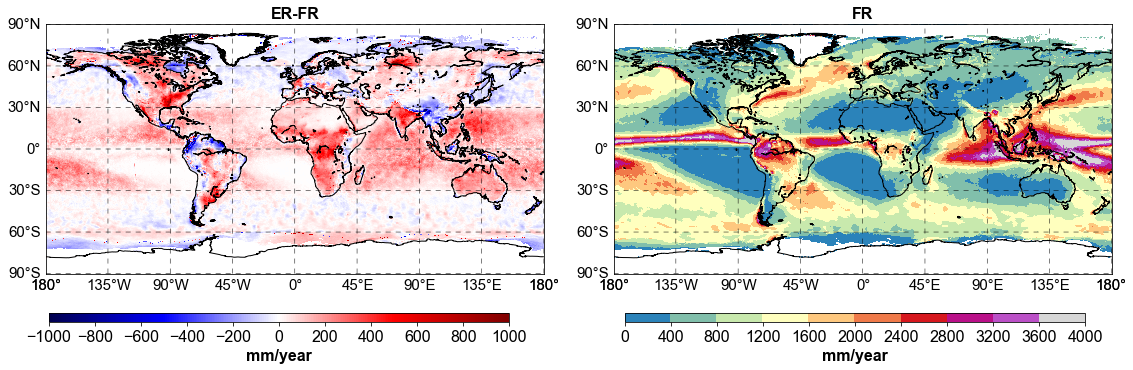

In [47]:
fig= plt.figure(figsize=(16,6))
ax= fig.add_subplot(121)
map= visual(annual_early-annual_final,cmap='seismic', vmin=-1000, vmax=1000)
cbar= fig.add_axes((0.05,0.1,0.4,0.02))
cbar= fig.colorbar(orientation= 'horizontal', mappable=map, cax=cbar, shrink=.5,
                  ticks=np.linspace(-1000, 1000, 11))
cbar.set_label('mm/year')
ax.set_title('ER-FR', weight='bold', fontsize=16)
ax= fig.add_subplot(122)
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
map= visual(annual_final, cmap=cmap, vmin=0, vmax=4000)

cbar= fig.add_axes((0.55,0.1,.4,.02))
cbar= fig.colorbar(orientation= 'horizontal', mappable=map, cax=cbar, shrink=0.5, fraction=0.5,
                  ticks=np.linspace(0, 4000, 11))
cbar.set_label('mm/year')
ax.set_title('FR', weight='bold', fontsize=16)

In [48]:
fig.savefig('annual_rainfall.png',dpi=300)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


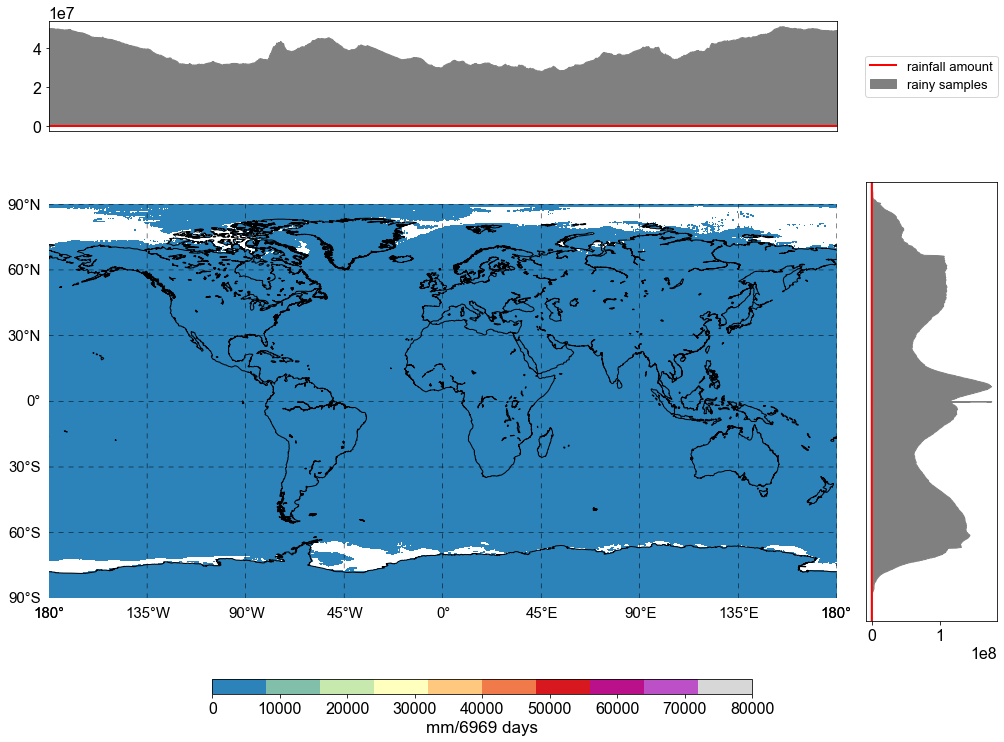

In [7]:
final_sum= result['final sum'][:]
final_sum[final_sum<0]= np.nan
annual= np.divide(final_sum, num, where=num!=0)
fig= marginal(annual, num, save=False, colorbar_label='mm/year', mark_max=False, cmap_range=(0,80000), cmap='jet')
# fig.savefig('total_amount.png', dpi=144)

In [6]:
early_sum= result['early sum'][:]
final_sum= result['final sum'][:]
early_sum[early_sum<=1]=np.nan
bias= early_sum/final_sum


In [7]:
from mpl_toolkits.basemap import Basemap

def visual(src, cmap= None, cmap_range=None,scale='linear'):
    def normalize(src, scale='linear'):
        if scale=='linear':
            return src
        elif scale=='log':
            return np.log(src)
        elif scale=='max_norm':
            return (src-np.nanmin(src))/(np.nanmax(src)-np.nanmin(src))
        elif scale=='std_norm':
            return (src-np.nanmean(src))/np.std(src[~np.isnan(src)])
    global lons, lats, lon_diff, lat_diff
    xres = lon_diff
    yres = lat_diff
    xmin = lats[0] + xres * 0.5
    xmax = lats[-1] - xres * 0.5
    ymin = lons[0] + yres * 0.5
    ymax = lons[-1] - yres * 0.5
    x,y = np.meshgrid(lons, lats)
    
#     fig= plt.figure(figsize=(20,8))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90, 91, 45), labels=[True,False,False,True], dashes=[10,10], linewidth=.5)
    m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True], dashes=[10,10], linewidth=.5)
    cmap= plt.get_cmap('rainbow') if cmap is None else plt.get_cmap(cmap)
    x,y = m(x,y)
    src= normalize(src, scale)
    if cmap_range is not None:
        map = m.pcolormesh(x,y,src, cmap=cmap, vmin=cmap_range[0], vmax=cmap_range[1])
    else:
        map = m.pcolormesh(x,y, src, cmap=cmap)
#     cb = m.colorbar(location="bottom", pad='10%')    
#     cb.set_label('mm')
    return map
#     basename = os.path.basename(FILE_NAME)
#     plt.title('{0}\n{1}'.format(basename, name+' (nchan1=0)'))
#     fig = plt.gcf()
#     pngfile = "{0}.py.png".format(basename)
#     fig.savefig(pngfile)

def marginal_mean(src, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False, scale='linear'):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    ax1= fig.add_subplot(spec[0,0])
    ax1.plot(lons, np.nanmean(src,axis=0), color='gray', label='mean along latitude')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.hlines(1.0, lons[0], lons[-1], color='red')
    ax1.set_ylim([0,2])
    ax1.legend()
    
    max_x, max_y= np.where(src==np.nanmax(abs(src)))
#     print(max_x, max_y, src.max())
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, cmap_range,scale=scale)
    
    if mark_max:
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    if mark_max:
        ax_spec= fig.add_subplot(spec[0,1])
        if cmap_range:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'), vmin= cmap_range[0], vmax= cmap_range[1])
        else:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'))
        ax_spec.set_xticklabels([])
        ax_spec.set_xticks([])
        ax_spec.set_yticklabels([])
        ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
    ax3.plot(np.nanmean(src,axis=1), lats, color='gray', label='mean along longitude')
    ax3.vlines(1,lats[0], lats[-1], color='red')
    ax3.set_ylim([-90,90])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_xlim([0,2])
#     ax3.legend()
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar(orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

def marginal_median(src, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False, scale='linear'):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    ax1= fig.add_subplot(spec[0,0])
    ax1.plot(lons, np.nanmedian(src,axis=0), color='gray', label='median along latitude')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
#     ax1.hlines(1.0, lons[0], lons[-1], color='red')
    ax1.set_ylim([0,2])
    ax1.legend()
    
    max_x, max_y= np.where(src==np.nanmax(abs(src)))
#     print(max_x, max_y, src.max())
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, cmap_range,scale=scale)
    
    if mark_max:
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    if mark_max:
        ax_spec= fig.add_subplot(spec[0,1])
        if cmap_range:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'), vmin= cmap_range[0], vmax= cmap_range[1])
        else:
            ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('bwr'))
        ax_spec.set_xticklabels([])
        ax_spec.set_xticks([])
        ax_spec.set_yticklabels([])
        ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
    ax3.plot(np.nanmedian(src,axis=1), lats, color='gray', label='median along longitude')
#     ax3.vlines(1,lats[0], lats[-1], color='red')
    ax3.set_ylim([-90,90])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_xlim([0,2])
#     ax3.legend()
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar(orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

In [7]:
fig= plt.figure(figsize=(10,6))
map= visual(bias, cmap='bwr')
# fig.savefig('early_final_ratio.png', dpi=144)

NameError: name 'bias' is not defined

<Figure size 720x432 with 0 Axes>

In [19]:
# array2raster('bias.tif',bias,lon_diff, lons, lat_diff, lats)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x116c918a0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x116c918a0> >


### early maximum intensity

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


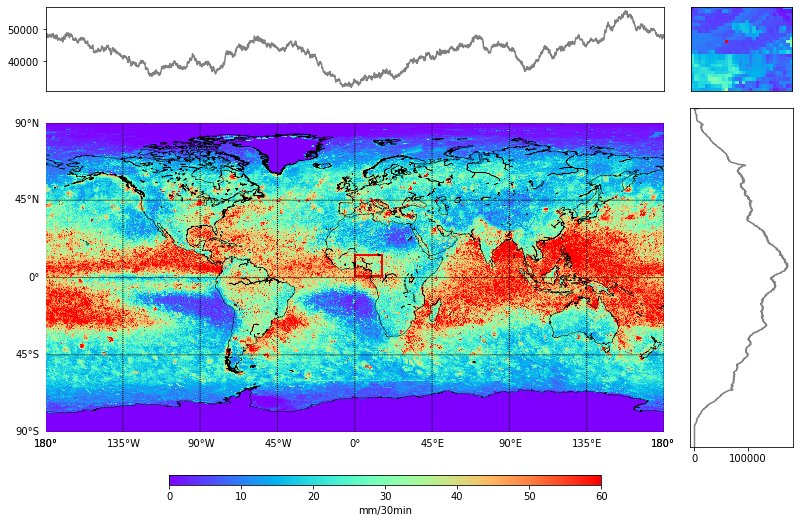

In [36]:
fig= marginal(result['early max'][:], colorbar_label='mm/30min', mark_max=True)

### Final maximum intensity

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


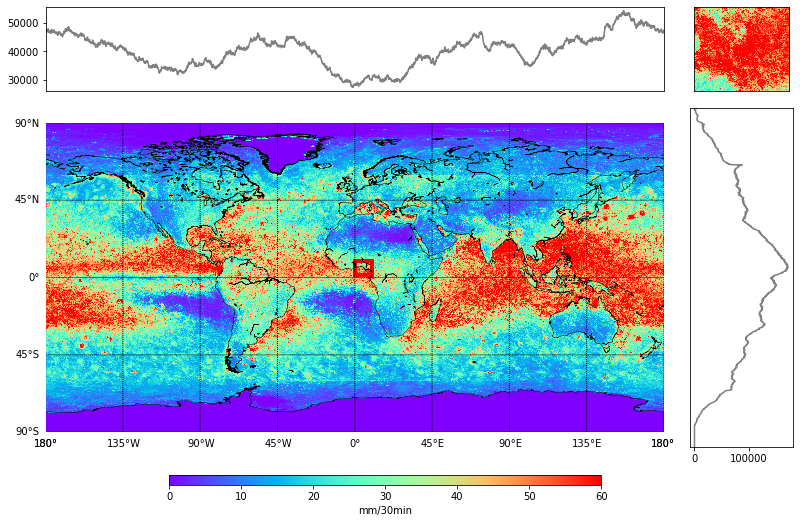

In [56]:
fig= marginal(result['final max'][:], colorbar_label='mm/30min',cmap_range=[0, 60], mark_max=True)
# fig.add_axes([0.])

In [6]:
early_max= result['early max'][:]
final_max= result['final max'][:]
early_max[early_max<=1]=np.nan
bias= final_max/early_max


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


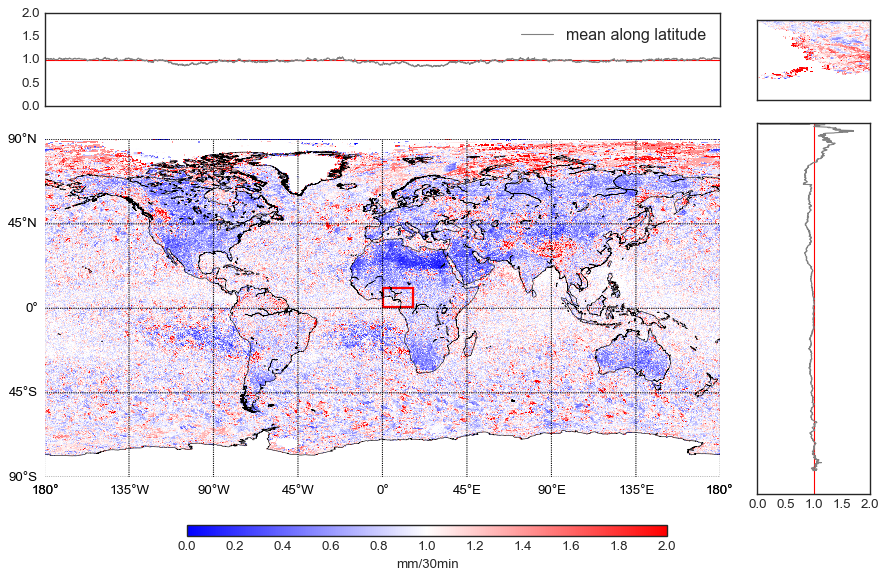

In [280]:
fig= marginal_mean(bias, colorbar_label='mm/30min', cmap='bwr', cmap_range=[0,2], mark_max=True)
fig.savefig('max_early_final_ratio.png', dpi=144)


### MAE

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


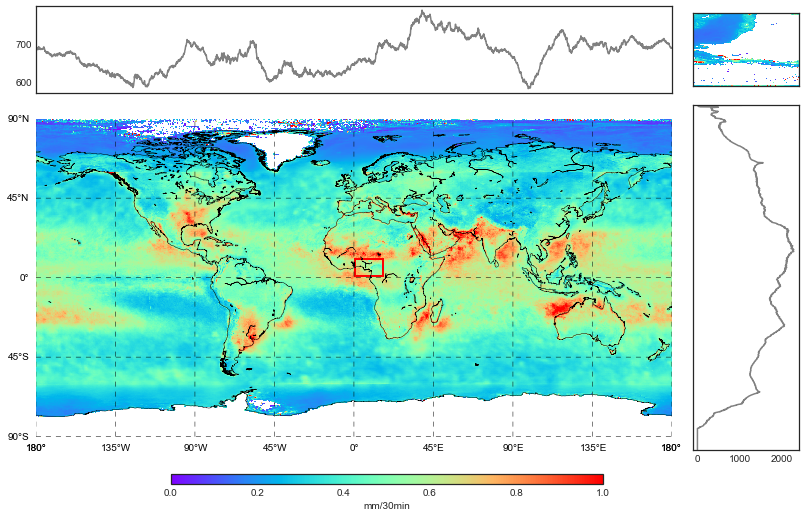

In [13]:
mae[mae==np.inf]=0
fig= marginal(mae,colorbar_label='mm/30min', cmap_range=(0,1), mark_max=False)
fig.savefig('mad.png', dpi=144)

In [57]:
final_rainy_num= (prob[:][0:2,:,:]).sum(axis=0)

#### RMSE


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


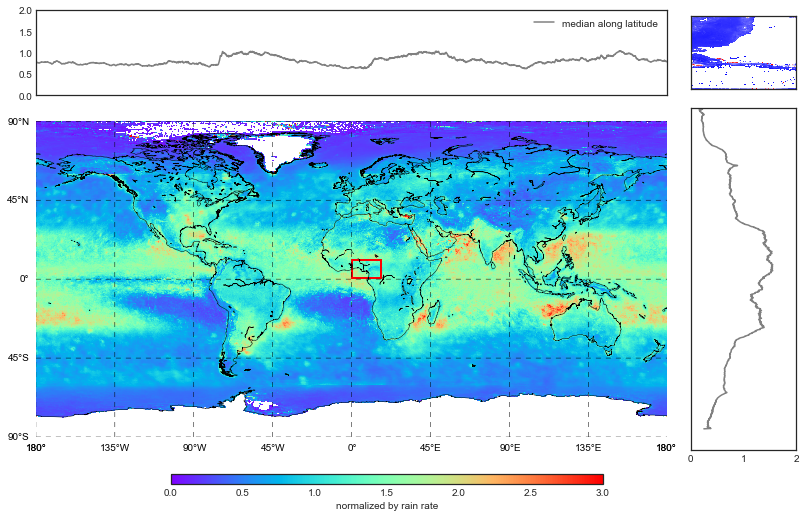

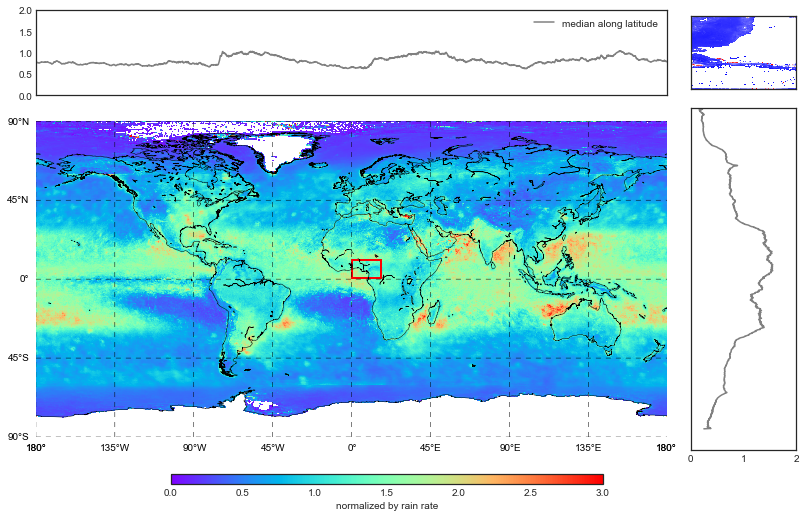

In [12]:
marginal_median(rmse,colorbar_label='normalized by rain rate',cmap_range=(0,3), mark_max=True, scale='linear')

In [9]:
fig= marginal_median(rmse/(final_sum/final_rainy_num),colorbar_label='normalized by rain rate',cmap_range=(0,2), mark_max=True, scale='linear')
# fig.savefig('rmse_divided_by_rainfall.png')

NameError: name 'final_sum' is not defined

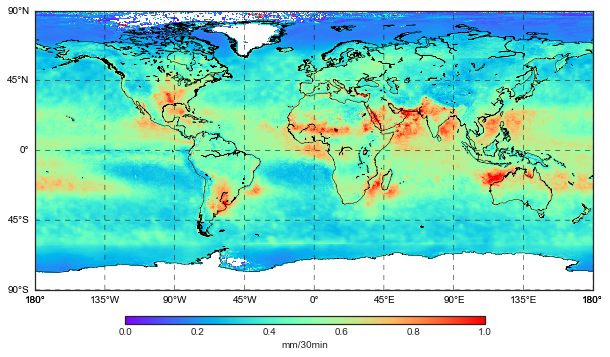

In [55]:
fig= plt.figure(figsize=(10,6))
map= visual(mae,cmap_range=(0,1))
cbar= fig.add_axes((0.25,0.1,.5,.02))
cb = plt.colorbar(orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
cb.set_label('mm/30min')
fig.savefig('mad.png',dpi=144)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


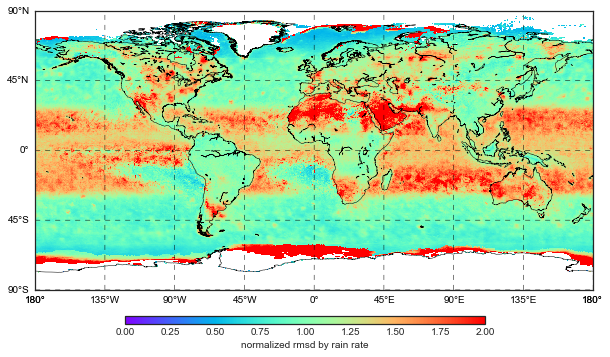

In [59]:
fig= plt.figure(figsize=(10,6))
map= visual(rmse/(final_sum/final_rainy_num),cmap_range=(0,2))
cbar= fig.add_axes((0.25,0.1,.5,.02))
cb = plt.colorbar(orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
cb.set_label('normalized rmsd by rain rate')
fig.savefig('rmsd_norm.png', dpi=144)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


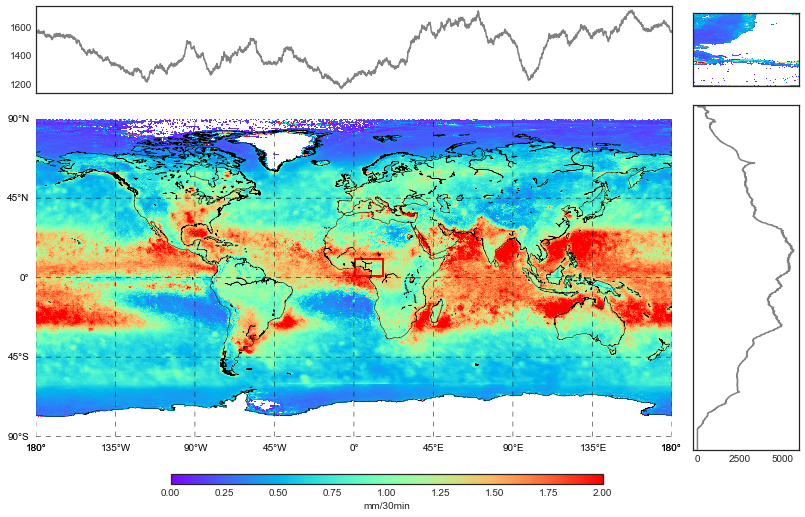

In [16]:
rmse[rmse==np.inf]= 0
fig= marginal(rmse/(final_sum/final_rainy_num),colorbar_label='mm/30min',cmap_range=(0,2), mark_max=True, scale='linear')
# fig.savefig('rmsd_norm.png', dpi=144)


In [ ]:
array2raster('total.tif', final_sum)

In [14]:
rmse[rmse==np.inf]= np.nan

In [51]:
array2raster('rmse_global.tif', rmse_land)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x13ad87ba0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x13ad87ba0> >


## FAR

In [473]:
array2raster('FAR.tif', FAR, lon_diff, lons, lat_diff, lats)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x14e96c570> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x14e96c570> >


In [119]:
_prob= result['prob']
a,b,c,d= _prob[0,:,:],_prob[1,:,:],_prob[2,:,:],_prob[3,:,:]
FAR= b/(a+b)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


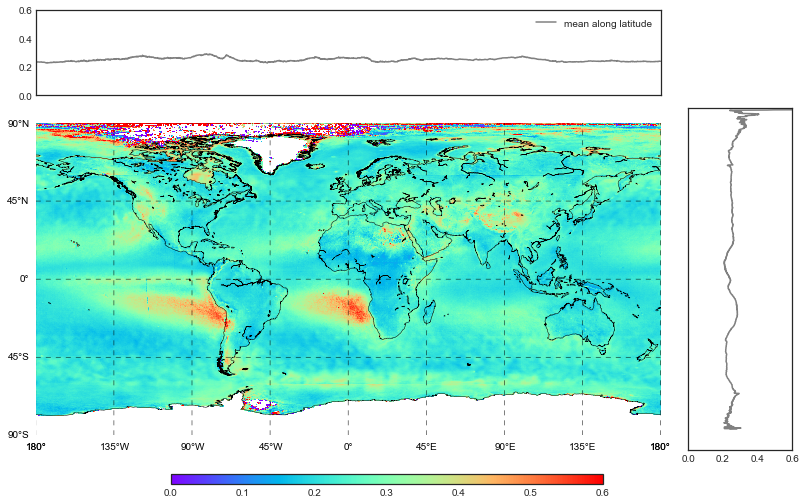

In [18]:

fig= marginal_mean(FAR, cmap_range=(0,0.6))
# plt.colorbar()
fig.savefig('FAR.png', dpi=144)

## Sea vs Land

In [6]:
from mpl_toolkits.basemap import Basemap

def visual(src, cmap= None, cmap_range=None):
    global lons, lats, lon_diff, lat_diff
    xres = lon_diff
    yres = lat_diff
    xmin = lats[0] + xres * 0.5
    xmax = lats[-1] - xres * 0.5
    ymin = lons[0] + yres * 0.5
    ymax = lons[-1] - yres * 0.5
    x,y = np.meshgrid(lons, lats)
    
#     fig= plt.figure(figsize=(20,8))
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90, 91, 45), labels=[True,False,False,True],  dashes=[10,10],linewidth=.5)
    m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True], dashes=[10,10], linewidth=.5)
    cmap= plt.get_cmap('rainbow') if cmap is None else plt.get_cmap(cmap)
    x,y = m(x,y)
    if cmap_range is not None:
        map = m.pcolormesh(x,y, src, cmap=cmap, vmin=cmap_range[0], vmax=cmap_range[1])
    else:
        map = m.pcolormesh(x,y, src, cmap=cmap)
#     cb = m.colorbar(location="bottom", pad='10%')    
#     cb.set_label('mm')
    return map
#     basename = os.path.basename(FILE_NAME)
#     plt.title('{0}\n{1}'.format(basename, name+' (nchan1=0)'))
#     fig = plt.gcf()
#     pngfile = "{0}.py.png".format(basename)
#     fig.savefig(pngfile)

def marginal_surface(src, alt, save=False, dst=None, colorbar_label=None, cmap_range=None, cmap=None, mark_max=False):
    global lon_diff, lat_diff
    widths= [6,1,0.3]
    heights= [1,4,0.3]
    fig= plt.figure(figsize=(12,7))
    fig.subplots_adjust(hspace=0)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                              height_ratios=heights)
    # fig.adjust_subplot(wspace=0.1)
    
    # accumulate number of samples
    
    ax1= fig.add_subplot(spec[0,0])
#     ax1.bar(lons, np.nansum(alt,axis=0)/np.nansum(alt), color='gray', alpha=0.4, label='num of samples')
    ax1.plot(lons, np.nanmedian(src,axis=0), color='red', label='rmse along latitude')
    ax1.set_xlim([-180,180])
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.legend()
    
    max_x, max_y= np.where(src==np.nanmax(src))
#     print(max_x, max_y, src.max())
    

    
    ax2= fig.add_subplot(spec[1,0], sharex=ax1, frame_on=False)
    map= visual(src, cmap, cmap_range)
    if mark_max:
        
        # Create a Rectangle patch
#         print(max_x, max_y)
#         for x,y in zip(max_x[0], max_y[0]):
        rect = patches.Rectangle((max_x[0]/3600., max_y[0]/1800.), 16, 10,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax2.add_patch(rect)
    
    max_lon= (max_y[0], max_y[0]+16/lon_diff)
    max_lat= (max_x[0], max_x[0]+10/lat_diff)
    
    ax_spec= fig.add_subplot(spec[0,1])
    if cmap_range:
        ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('rainbow'), vmin= cmap_range[0], vmax= cmap_range[1])
    else:
        ax_spec.imshow(src[max_x[0]-150:max_x[0]+160, max_y[0]-150:max_y[0]+200], cmap=plt.get_cmap('rainbow'))
    ax_spec.set_xticklabels([])
    ax_spec.set_xticks([])
    ax_spec.set_yticklabels([])
    ax_spec.set_yticks([])

    ax3= fig.add_subplot(spec[1,1])
#     ax3.plot(alt.sum(axis=1)/alt.sum(), lats, color='gray', alpha=0.4, label='num of samples')
    ax3.fill_between(alt.sum(axis=1)/alt.sum(), lats, color='gray')
    ax3.plot(np.nanmean(src,axis=1), lats, color='red', label='rmse along latitude')
    ax3.set_ylim([-90,90])
    ax3.set_xlim([0,5])
    ax3.set_yticklabels([])
    ax3.set_yticks([])
#     ax3.legend()
    cbar= fig.add_axes((0.2,0.03,.5,.02))
    cb = plt.colorbar( orientation='horizontal', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
    if colorbar_label is not None:
        cb.set_label(colorbar_label)
    if save:
        fig.savefig(dst, dpi=144)
    fig.tight_layout(h_pad=0)
        
    return fig

In [144]:
glob_cls= gdal.Open('geotiffs/RenderData.tiff')
glob_cls= glob_cls.ReadAsArray()
glob_cls= np.flip(glob_cls, axis=0)
# rmse= gdal.Open('rmse_for_dem.tif')
# rmse= rmse.ReadAsArray()
# rmse_norm= rmse/(final_sum/np.nansum(result['prob'][[0,1],:,:],axis=0))
final_sum=result['final sum'][:]

In [145]:
sea= np.where(glob_cls==0)
land= np.where(glob_cls!=0)

In [146]:
final_sum[final_sum<0]=np.nan
rmse[rmse<0]= np.nan
samples= np.nansum(result['prob'][:][[0,1],:,:],axis=0)
# samples[np.isnan(samples)]= -9999


normSamples= np.divide(final_sum, samples, where= samples!=0, out= np.full(final_sum.shape, np.nan))
rmse_land= np.divide(rmse.copy(), normSamples, where= normSamples!=0, out= np.full(rmse.shape, np.nan))
rmse_land[sea]=np.nan
rmse_sea= np.divide(rmse.copy(), normSamples, where= normSamples!=0, out= np.full(rmse.shape, np.nan))
# rmse_land= rmse.copy()
# rmse_sea= rmse.copy()
rmse_sea[land]=np.nan
num_land= num.copy()
num_land[sea]= 0
num_sea= num.copy()
num_sea[land]= 0
rmse_coast= pd.read_csv('shoreline_pnts_ex60.csv').to_numpy()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [147]:
# North hemisphere
# rmse_land[0:300,:]= np.nan
# rmse_sea[0:300,:]= np.nan
rmse_land[300:1500,:]= np.nan
rmse_sea[300:1500,:]= np.nan
# rmse_land[600:900,:]= np.nan
# rmse_sea[600:900,:]= np.nan

# rmse_land[1500:1800,:]= np.nan
# rmse_sea[1500:1800,:]= np.nan

In [153]:
rmse_coast.shape

(164314,)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


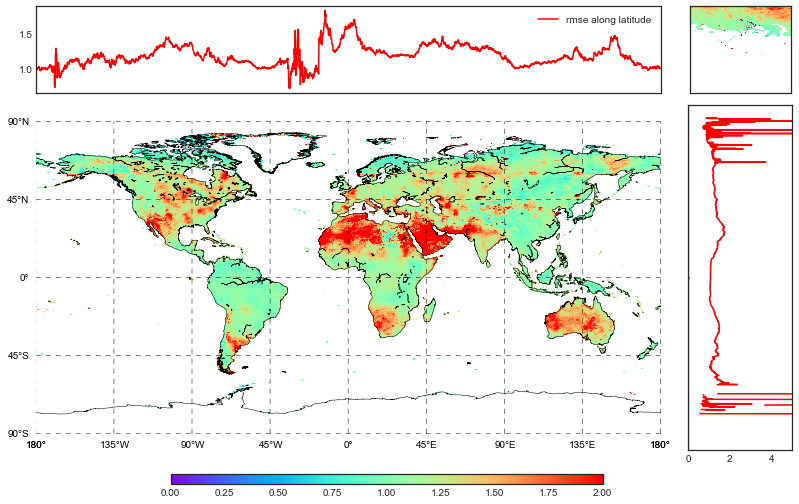

In [146]:
fig= marginal_surface(rmse_land, num_land, cmap_range=(0,2), mark_max=False)
# fig.savefig('land_rmse_norm.png', dpi=144) 

In [ ]:
fig= marginal_surface(rmse_land, num_land, cmap_range=(0,2), mark_max=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


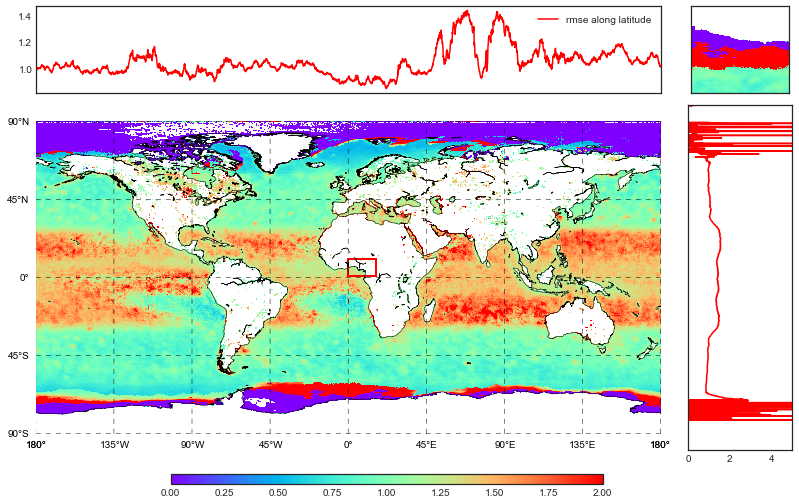

In [211]:
fig= marginal_surface(rmse_sea, num_sea, cmap_range=(0,2), mark_max=True)
fig.savefig('ocean_rmse_norm.png', dpi=144)

In [150]:
def clean(rmse_land, rmse_sea, rmse_coast):
    rmse_land= rmse_land.reshape(1,-1)
    rmse_land= rmse_land[~np.isnan(rmse_land)]
    rmse_land= rmse_land[(rmse_land<np.quantile(rmse_land, .95)) & (rmse_land>np.quantile(rmse_land, .05))]
    rmse_sea= rmse_sea.reshape(1,-1)
    rmse_sea= rmse_sea[~np.isnan(rmse_sea)]
    rmse_sea= rmse_sea[(rmse_sea<np.quantile(rmse_sea, .95)) & (rmse_sea>np.quantile(rmse_sea, .05))]
    rmse_coast= rmse_coast[~np.isnan(rmse_coast)]
    rmse_coast= rmse_coast[(rmse_coast<np.quantile(rmse_coast, .95)) & (rmse_coast>np.quantile(rmse_coast, .05))]
    
    return rmse_land, rmse_sea, rmse_coast

In [120]:
import seaborn as sns

In [132]:
rmse_land_all= rmse_land.copy()
rmse_sea_all= rmse_sea.copy()
rmse_coast_all= rmse_coast.copy()

In [138]:
rmse_land_30= rmse_land.copy()
rmse_sea_30= rmse_sea.copy()
rmse_coast_30= rmse_coast.copy()

In [143]:
rmse_land_30_60= rmse_land.copy()
rmse_sea_30_60= rmse_sea.copy()
rmse_coast_30_60= rmse_coast.copy()

In [148]:
rmse_land_60= rmse_land.copy()
rmse_sea_60= rmse_sea.copy()
rmse_coast_60= rmse_coast.copy()

In [151]:
rmse_land_all, rmse_sea_all, rmse_coast_all= clean(rmse_land_all, rmse_sea_all, rmse_coast_all)
rmse_land_30, rmse_sea_30, rmse_coast_30= clean(rmse_land_30, rmse_sea_30, rmse_coast_30)
rmse_land_30_60, rmse_sea_30_60, rmse_coast_30_60= clean(rmse_land_30_60, rmse_sea_30_60, rmse_coast_30_60)
rmse_land_60, rmse_sea_60, rmse_coast_60= clean(rmse_land_60, rmse_sea_60, rmse_coast_60)

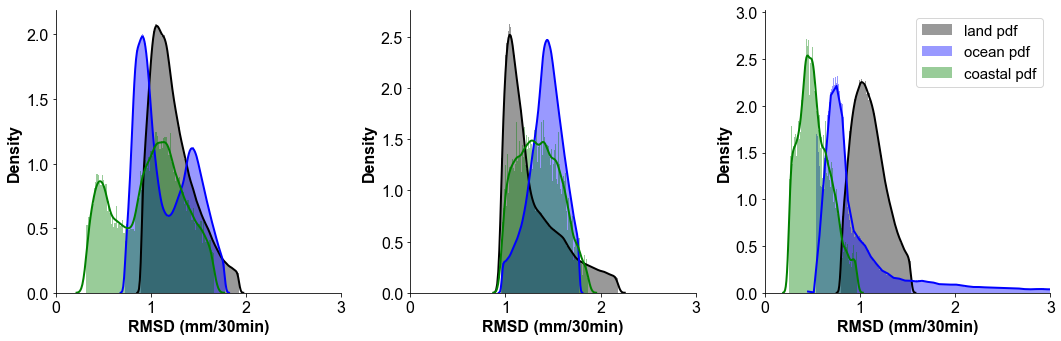

In [167]:
fig= plt.figure(figsize=(15,5))
ax_0= fig.add_subplot(131)
ax_0= sns.distplot(rmse_land_all, color='black', label='land pdf', bins=100);
ax_0= sns.distplot(rmse_sea_all, color= 'blue', label='ocean pdf', bins=100);
ax_0= sns.distplot(rmse_coast_all, color='green', label='coastal pdf', bins=100);
ax_0.set_xlim([0,3])
ax_0.set_xlabel('RMSD (mm/30min)', fontsize=16)
ax_0.set_ylabel('Density', fontsize=16)
ax_0.spines['top'].set_visible(False)
ax_0.spines['right'].set_visible(False)
ax_0= fig.add_subplot(132)
ax_0= sns.distplot(rmse_land_30, color='black', label='land pdf', bins=100);
ax_0= sns.distplot(rmse_sea_30, color= 'blue', label='ocean pdf', bins=100);
ax_0= sns.distplot(rmse_coast_30, color='green', label='coastal pdf', bins=100);
ax_0.set_xlim([0,3])
ax_0.set_xlabel('RMSD (mm/30min)', fontsize=16)
ax_0.set_ylabel('Density', fontsize=16)
ax_0.spines['top'].set_visible(False)
ax_0.spines['right'].set_visible(False)
# ax_0= fig.add_subplot(223)
# ax_0= sns.distplot(rmse_land_30_60, color='black', label='land pdf', bins=100);
# ax_0= sns.distplot(rmse_sea_30_60, color= 'blue', label='ocean pdf', bins=100);
# ax_0= sns.distplot(rmse_coast_30_60, color='green', label='coastal pdf', bins=100);
# ax_0.set_xlim([0,3])
# ax_0.set_xlabel('RMSD (mm/30min)', fontsize=16)
# ax_0.set_ylabel('Density', fontsize=16)
# ax_0.spines['top'].set_visible(False)
# ax_0.spines['right'].set_visible(False)
ax_0= fig.add_subplot(133)
ax_0= sns.distplot(rmse_land_60, color='black', label='land pdf', bins=100);
ax_0= sns.distplot(rmse_sea_60, color= 'blue', label='ocean pdf', bins=1000);
ax_0= sns.distplot(rmse_coast_60, color='green', label='coastal pdf', bins=100);
ax_0.set_xlim([0,3])
ax_0.spines['top'].set_visible(False)
ax_0.spines['right'].set_visible(False)
ax_0.legend(fontsize=15)
ax_0.set_xlabel('RMSD (mm/30min)', fontsize=16)
ax_0.set_ylabel('Density', fontsize=16);

In [168]:
fig.savefig('err_pdf.png', dpi=300)

In [161]:
np.nanmax(rmse_sea_all)-np.nanmin(rmse_sea_all) 

1.0484776219412693

In [168]:
lons= np.array(GPCC.lon)-180
lats= np.array(GPCC.lat)
lon_diff= lons[2]- lons[1]
lat_diff= lats[2]- lats[1]
array= np.array(GPCC.precip[-1])
new_arr= np.zeros(array.shape)
new_arr[:,:360]= array[:, 360:]
new_arr[:,360:]= array[:, :360]
array2raster('GPCC_gauges.tif', new_arr, lon_diff, lons, lat_diff, lats)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10b93fb10> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10b93fb10> >


In [310]:
sum_land= final_sum.copy()
sum_land[sea]=np.nan
sum_sea= final_sum.copy()
sum_sea[land]=np.nan

## Correlation between orographic faetures and adjustments

In [55]:
dem= gdal.Open('geotiffs/global_elevation.tif')
rmse= gdal.Open('geotiffs/rmse_for_dem.tif')
cls_land= gdal.Open('geotiffs/cls_for_dem.tif')
# bias= gdal.Open('geotiffs/bias.tif')

In [60]:
arr_dem= dem.ReadAsArray()
arr_rmse= np.flip(rmse.ReadAsArray(), axis=0)
sea= np.where(cls_land.ReadAsArray()==0)
arr_dem[sea]= np.nan
arr_rmse[sea]= np.nan
# early_max= result['early max'][:]
# final_max= result['final max'][:]
# early_max[early_max<=1]=np.nan
# bias= np.divide(early)
bias= np.flip(early_sum/final_sum, axis=0)

NameError: name 'early_sum' is not defined

In [52]:

arr_dem= arr_dem.reshape(-1,1)
bias= bias.reshape(-1,1)

arr_dem= arr_dem[~np.isnan(arr_dem)]
bias= bias[~np.isnan(bias)]

In [16]:
def max_min_normlize(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

def mean_normalizer(arr):
    return (arr-arr.mean())/np.std(arr)

In [26]:
def split_elev(dem, bins):
    _, value= np.histogram(dem, bins= bins)
    return value

In [219]:
bin_width= np.arange(0,6500,500)
grouped_ind= [np.where((arr_dem>=bin_width[i]) & (arr_dem<bin_width[i+1])) for i in range(len(bin_width)-1)]

In [222]:
grouped_rmse= [arr_rmse[group] for group in grouped_ind]

IndexError: index 1405 is out of bounds for axis 0 with size 1400

### plot land-ocean zonal relative bias/differences in one graph

Behavior like [An Update on the Oceanic Precipitation Rate and Its Zonal Distribution in
Light of Advanced Observations from Space](https://journals.ametsoc.org/doi/pdf/10.1175/JCLI-D-13-00679.1)

## Zonal Analysis

In [5]:
def hist(x, bins=18):
    value, base= np.histogram(x, bins=bins)
    
    return value, base

In [6]:
prob= result['prob']
early_rain= prob[:][0,:,:]+prob[:][2,:,:]
final_rain= prob[:][0,:,:]+prob[:][1,:,:]
early_sum= result['early sum'][:]
final_sum= result['final sum'][:]
early_sum[early_sum<0]= 0
final_sum[final_sum<0]= 0

In [15]:
early_day_base= [np.nanmean(np.nanmean(early_rain,axis=1)[i*100:(i+1)*100])/19. for i in range(18)]
final_day_base= [np.nanmean(np.nanmean(final_rain,axis=1)[i*100:(i+1)*100])/19. for i in range(18)]
early_sum_base= [np.nanmean(np.nanmean(annual_early, axis=1)[i*100:(i+1)*100]) for i in range(18)]
final_sum_base= [np.nanmean(np.nanmean(annual_final, axis=1)[i*100:(i+1)*100]) for i in range(18)]

bin_width= range(-90,100,10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [18]:
np.sum(final_sum_base[6:11])/np.nansum(final_sum_base)

0.39709816548201793

In [80]:
np.nanmax(early_sum_base[6:11])

2229.0452231687495

In [81]:
np.nanmax(final_sum_base[6:11])

2127.97294459553

In [102]:
(np.array(early_day_base)- np.array(final_day_base))/np.array(final_day_base)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([        nan, -0.11957361, -0.08086326, -0.04007456, -0.05290062,
       -0.04211482, -0.02319503, -0.05812078, -0.0576324 , -0.06630029,
       -0.04314145, -0.03487658, -0.04943828, -0.04933113, -0.0549688 ,
       -0.02923816, -0.08575526, -0.13625236])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


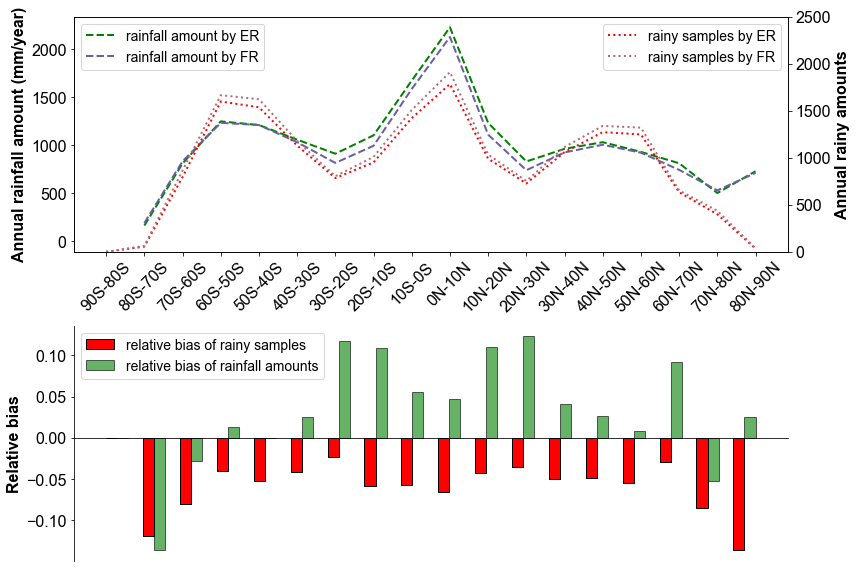

In [108]:
# early_day_value, early_base= hist(early_rain.sum(axis=1))
# final_day_value, final_base= hist(final_rain.sum(axis=1))
# early_sum_value, _= hist(early_sum.sum(axis=1))
# final_sum_value, _= hist(final_sum.sum(axis=1))
xlabels= [str(i) for i in range(-85, 95, 10)]
N= np.arange(18)
width=0.3

fig, ax= plt.subplots(2,1, figsize=(12,8))
# ax[0].plot(N, annual_final, width, color='red', label='rainy samples by Final')
# ax[0].plot(N, annual_early, width, color='blue',   label='rainy samples by Early')

line1=ax[0].plot(N, early_sum_base, width, color='green',linestyle='dashed',  label='rainfall amount by ER')
line2= ax[0].plot(N, final_sum_base, width, color='#6960A1',linestyle='dashed', label='rainfall amount by FR')
ax[0].legend((line1[0], line2[0]), ('rainfall amount by ER', 'rainfall amount by FR'), loc= 'upper left')
ax[0].set_ylabel('Annual rainfall amount (mm/year)')
ax2= ax[0].twinx()
ax2.plot(N, early_day_base, 'red', linestyle=':', label='rainy samples by ER')
ax2.plot(N, final_day_base, '#AE6C75', linestyle=':', label='rainy samples by FR')
ax2.legend(loc='upper right')
ax2.set_ylim([0, 2500])
ax2.set_ylabel('Annual rainy amounts')
for i in range(18):
    if bin_width[i]<0: labels.append('%dS-%dS'%(abs(bin_width[i]), abs(bin_width[i+1])))
    else: labels.append('%dN-%dN'%(abs(bin_width[i]), abs(bin_width[i+1])))
ax[0].set_xticks(np.arange(18))
ax[0].set_xticklabels(labels);
ax[0].xaxis.set_tick_params(rotation=45)

sample= (np.array(early_day_base)- np.array(final_day_base))/np.array(final_day_base)
sample[0]= 0
rain= (np.array(early_sum_base)- np.array(final_sum_base))/np.array(final_sum_base)
rain[0]= 0

ax[1].bar(N-width/2, sample,width,edgecolor='black', color='red',label='relative bias of rainy samples')
ax[1].bar(N+width/2, rain, width, color='green', alpha=0.6, edgecolor='black', label='relative bias of rainfall amounts')

# ax[1].set_xlim([0,18])
ax[1].legend()
ax[1].set_xticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylabel('Relative bias')
ax[1].spines['bottom'].set_position(('data', 0))
plt.tight_layout()
fig.savefig('zonal_rainy_update.png', dpi=300)

In [21]:
rain= (np.array(early_sum_base)- np.array(final_sum_base))/np.array(final_sum_base)

In [22]:
sample= (np.array(early_day_base)- np.array(final_day_base))/np.array(final_day_base)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [35]:
sample_bias= np.divide(early_rain-final_rain, final_rain, where=~np.isnan(final_rain))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [36]:
sample_bias[sample_bias==np.inf]= np.nan

In [40]:
np.nanpercentile(sample_bias,1)

-0.3443708609271523

In [38]:
np.nanmin(sample_bias)

-1.0

In [33]:
np.nanmean(np.divide(early_rain-final_rain, final_rain, where=~np.isnan(final_rain)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


inf

### Gauge-rmsd correlation

In [7]:
import geopandas as gpd
from osgeo import gdal
import affine

In [461]:
def latSplit(total, space=10):
    # :num -  int, the numbers that split 1800 into; default=10
    rmse_raster= gdal.Open('geotiffs/rmse_global.tif')
    geotrans= rmse_raster.GetGeoTransform()
    arr= rmse_raster.ReadAsArray()
    pnts= gpd.read_file('gisSrc/gauge_pnt_vector.shp')
    labels= []
    deg= int(180//space)
    bin_widths= np.arange(-90, 90+space, space)
    # print(bin_widths)
    for i in range(deg):
        # print(bin_widths[i])
        if i<deg/2: labels.append('%dS-%dS'%(-bin_widths[i], -bin_widths[i+1]))
        else: labels.append('%dN-%dN'%(bin_widths[i], bin_widths[i+1]))
    # print(labels)
    #zonal rmse, mae
    forward_transform = affine.Affine.from_gdal(*geotrans)
    results= [~forward_transform * np.array(pnts.geometry[i]) for i in range(len(pnts))]
    values= [pnts.VALUE[i] for i in range(len(pnts))]
    y= [int(results[j][1]+0.5) for j in range(len(pnts))]
    x= [int(results[j][0]+0.5) for j in range(len(pnts))]
    gaugeRMSE= []
    gaugeRain= []
    for i in range(len(pnts)):
        if x[i]<3600:
#             print(y[i])
            gaugeRMSE.append(arr[y[i], x[i]])
            gaugeRain.append(total[y[i], x[i]])
        else:
            gaugeRMSE.append(arr[y[i], 3599])
            gaugeRain.append(total[y[i], 3599])
    dictRMSE= {}
    gaugeRMSE= np.array(gaugeRMSE)
    gaugeRain= np.array(gaugeRain)
    for i in range(deg):
        arrRange= int(10*space)
        latRange= [i*arrRange, (i+1)*arrRange]
#         print(latRange)
        masks= list(map(lambda x:True if latRange[1]>x>=latRange[0] else False, y))
        numGauge= sum(masks)
#     print(masks)
        numSat= np.sum(~np.isnan(arr[latRange[0]:latRange[1],:]))
        rmse_lat= np.nanmedian(arr[latRange[0]:latRange[1],:])
        rmse_lat_norm= np.nanmedian(arr[latRange[0]:latRange[1],:]/np.poly1d(z)(total[latRange[0]:latRange[1],:]/6969/48**.5))
        gaugeRMSEAcc= np.nanmedian(np.array(gaugeRMSE[masks]))
        gaugeRMSENorm= np.nanmedian(np.array(gaugeRMSE[masks])/np.poly1d(z)(gaugeRain[masks]/6969/48**.5))
                               
        dictRMSE[labels[i]]= [rmse_lat,rmse_lat_norm, gaugeRMSEAcc,gaugeRMSENorm, numGauge, numSat,np.nanmedian(total[latRange[0]:latRange[1],:]),np.nanmedian(gaugeRain[masks]) ]

    return dictRMSE

In [462]:
_dict_1= latSplit(final_sum, 1)
_dict_10= latSplit(final_sum, 10)

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [300]:
ind= list(_dict_10.keys())[3:-3]

In [13]:
def normalize(x, method='mean'):
    if method=='mean':
        xMean= np.nanmean(x)
        xStd= np.nanstd(x)
        return (x-xMean)/xStd
    elif method=='minmax':
        return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

In [261]:
normalize(np.array([_dict_10[key][1] for key in ind]), method='minmax')+0.2

array([1.15692845, 0.50909592, 1.06595589, 1.2       , 0.66349945,
       0.25519376, 0.2       , 0.55128507, 0.52593287, 0.96838154,
       0.71872159, 0.69779   ])

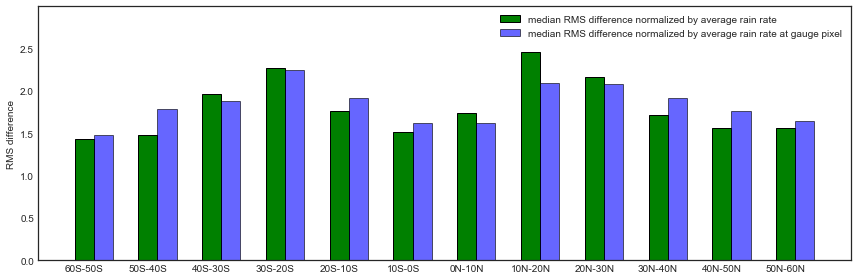

In [468]:
fig= plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=0)
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[4,1])
ax1= fig.add_subplot(spec[0])
ax1.bar(range(len(ind)), np.array([_dict_10[key][1] for key in ind]), color='green', width=0.3,edgecolor='black', label='median RMS difference normalized by average rain rate')
# ax1.set_ylim([0,1.4])
# ax1_1= ax1.twinx()
ax1.bar(np.arange(len(ind))+0.3, np.array([_dict_10[key][3] for key in ind]), color='blue', width=0.3,edgecolor='black', label='median RMS difference normalized by average rain rate at gauge pixel', alpha=0.6)
# ax1.set_ylim([0,1.4])
ax1.set_xticks(range(len(ind)))
ax1.set_xticklabels(ind)
ax1.set_ylim([0,3])
ax1.set_yticks(np.arange(0,3.5,0.5))
ax1.set_yticklabels(np.arange(0,3,0.5))
plt.legend()
ax1.set_ylabel('RMS difference')
# handles_1, labels_1 = ax.get_legend_handles_labels()
# handles_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.get_legend().remove()
# ax2.get_legend().remove()
# labels_1= labels_1+ labels_2
# handles_1= handles_1+ handles_2
# ax_add= fig.add_axes((.8,0.78,0.1,0.1), facecolor='white', xticks=[], yticks=[], frameon=False)
# ax_add.set_facecolor("white")
# ax2= fig.add_subplot(spec[1])
# rmsd= np.array([_dict_1[key][0] for key in _dict_1.keys()])
# rain= np.array([_dict_1[key][-2] for key in _dict_1.keys()])/6969/48

# common= (np.isnan(rain)) | (np.isnan(rmsd) | (rmsd==np.inf))
# rmsd= rmsd[~common]
# rain= rain[~common]
# ax2.scatter(rain, rmsd, color='white', edgecolor='black')
# # ax2.plot([0,.5],[0,1.], color='red')
# ax2.text(0.35,0.4,'CC: %.2f\n'%(r2_score(rain, rmsd)))
# ax2.set_xlabel('rain rate (mm/30min)')
# ax2.set_ylabel('rmsd (mm/30min)')
# ax2.set_xlim([0,0.5])
# ax2.set_ylim([0,1])
plt.tight_layout()
# fig.savefig('gaugeImpact.png', dpi=144)

In [20]:
def quantileCC(rain, rmsd):
    rain= rain.reshape(-1,1)
    rmsd= rmsd.reshape(-1,1)
    mask= (~np.isnan(rain)) & (np.isnan(rmsd)) & (rain!=np.inf) & (rmsd!=np.inf)
    rain= rain[mask]**.5
    rmsd= rmsd[mask]
    

In [38]:
def binedRain(rain, rmsd):
    rain= (rain.reshape(-1,1)/6969)**.5
    rmsd= rmsd.reshape(-1,1)
    base= np.arange(0,5,0.1)
    stats= {'rain':[],
           'median':[],
           '75':[],
           '25':[],}
    for i in range(len(base)-1):
        mask= (rain>base[i]) & (rain< base[i+1])
        stats['rain'].append((base[i]+base[i+1])/2)
        stats['median'].append(np.nanmedian(rmsd[mask]))
        stats['25'].append(np.nanquantile(rmsd[mask], 0.25))
        stats['75'].append(np.nanquantile(rmsd[mask], 0.75))
        
    return stats

In [39]:
final_sum= result['final sum'][:]
final_sum[final_sum<0]= np.nan
binStats= binedRain(final_sum, rmse)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [40]:
x= np.concatenate([binStats[key] for key in ['median','25', '75']]).reshape(49,3)
y = binStats['rain']

In [41]:
z= np.polyfit(y,binStats['median'],1)

In [25]:
def line(x, k, m):
    x= np.array(x)
    return k*x+m

In [33]:
z

array([nan, nan])

Text(0.5, 0, 'squared rain rate $(mm/day)^{0.5}$')

Text(0, 0.5, 'RMS difference (mm/30min)')

(0, 5)

Text(0.5, 1.8, 'CC: 0.94\nLSE: 1.08')

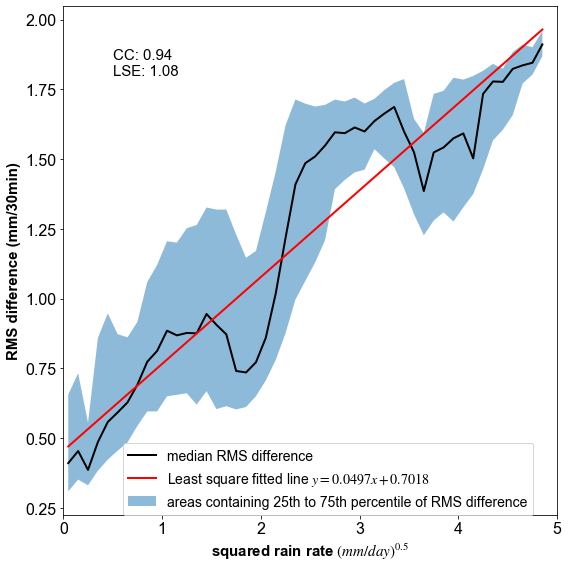

In [42]:
fig= plt.figure(figsize=(8,8))
plt.plot(binStats['rain'], binStats['median'], color='black', linewidth=2, label='median RMS difference')
plt.fill_between(binStats['rain'], binStats['25'], binStats['75'], alpha=0.5, label='areas containing 25th to 75th percentile of RMS difference')
plt.plot(y, np.poly1d(z)(y), color='red', label='Least square fitted line $y=0.0497x+0.7018$')
plt.legend(loc=(0.12, 0))
plt.xlabel('squared rain rate $(mm/day)^{0.5}$', fontsize=15)
plt.ylabel('RMS difference (mm/30min)', fontsize=15)
plt.xlim([0,5])
plt.text(0.5, 1.8, 'CC: %.2f\nLSE: %.2f'%(np.corrcoef(y,binStats['median'])[0,1], ((binStats['median']-np.poly1d(z)(y))**2).sum()**.5), fontsize=15)
# fig.savefig('corr_rain_rmsd_daily.png', dpi=144)
# plt.plot()

In [10]:
stats= pd.read_csv('zoneRmsdRain.csv')

In [11]:
with open('legend.txt', 'r') as f:
    legends= f.readlines()

In [12]:
def classifyZone(code):
    with open('legend.txt', 'r') as f:
        legends= f.readlines()
    _dict= {legend.split(' ')[0]: legend.split(' ')[-1].split('\n')[0] for legend in legends}
#     print(_dict)
    return _dict[str(code)]

In [13]:
stats['zone']= stats.GRIDCODE.map(classifyZone)
stats.set_index('zone', inplace=True)

In [14]:
stats= stats[~pd.isna(stats._rainAmo_2) & ~pd.isna(stats._median) & (stats._rainAmo_2>0)]

In [19]:
stats['norm_rain']= stats._median/(stats._rainAmo_2/6969)**.5

In [20]:
rmseZoneMedian= stats.groupby('zone')['_median'].median()
rmseZoneMedianNorm= (stats.groupby('zone')['_median'].median()-0.4547)/((stats.groupby('zone')['_rainAmo_2'].mean()/6969)**.5)
rmseZoneGaugeMedian= stats.groupby('zone')['gauge_rm_1'].median()
rmseZoneGaugeMedianNorm= (stats.groupby('zone')['gauge_rm_1'].median()-0.4547)/((stats.groupby('zone')['_rainAmo_2'].mean()/6969)**.5)
gaugeZoneDensity= stats.groupby('zone')['gauge_sum'].sum()/stats.groupby('zone')['gauge_sum'].sum().max()

In [106]:
np.nanmean(stats.groupby('zone')['gauge_sum'].sum()[29:])

111.62499999999999

In [55]:
np.nanmedian(np.concatenate(zoneRMSDs[29:]))

0.9123305377244796

Rank by main climates:  
equatorial: 1.15  
Arid: 1.86  
Warm climate: 1.21   
Snow: 1.16
Polar: 0.91

Rank by temperature:  
hot arid: 1.90  
cold arid: 1.79  
hot summer: 1.33  
warm summer: 1.11  
cold summer: 1.07  
extremely continental: 1.67  
polar: 0.87  

In [63]:
np.nanmedian(zoneRMSDs[8].append(zoneRMSDs[11]).append(zoneRMSDs[14])

1.7934827224560177

In [72]:
np.nanmedian(np.concatenate([zone.values for zone in zoneRMSDs if zone.index[0][-1]=='T']))

0.9227637659951586

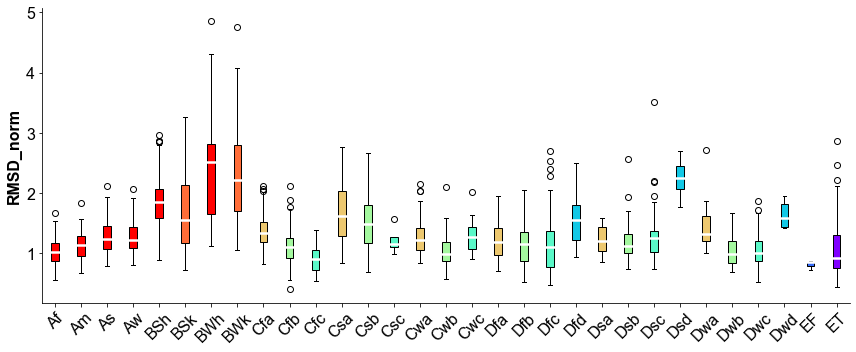

In [59]:
rain= [np.nanmean(stats.loc[zone]['_rainAmo_2'][stats.loc[zone]['_rainAmo_2']>0]) for zone in np.unique(sorted(stats.index))]
zoneRMSDs= [(stats.loc[zone]._median[~np.isnan(stats.loc[zone]._median)])/((rain[i]/6969)**.5)*2
            for i,zone in enumerate(np.unique(sorted(stats.index)))]
# zoneRMSDs= stats.groupby('zone')['norm_rain']
# del zoneRMSDs[-2]
colors = plt.matplotlib.cm.rainbow(np.linspace(0, 1, 8))
ranks= 'TFdcbakh'
fig= plt.figure(figsize=(12,5))
ax= fig.add_subplot()
i=0
for i, zone in enumerate(zoneRMSDs):
    name= zone.index[0]
#     zone= zone[1]
    color= colors[ranks.find(name[-1]),:]
    ax.boxplot(zone, positions=[i], widths=.3, patch_artist=True,
               boxprops=dict(facecolor=color),medianprops = dict(linewidth=2.5, color='white'))
# ax.boxplot([_rmsd[~np.isnan(_rmsd)] for _rmsd in zoneRMSDs], positions= np.arange(31)
#           patch_artist=True, );
    i+=1
ax.set_xticks(np.arange(31))
ax.set_xticklabels( [zone.index[0] for zone in zoneRMSDs], rotation=45);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('RMSD_norm');

In [23]:
fig.savefig('climZoneStat_woGauge.png', dpi=300)

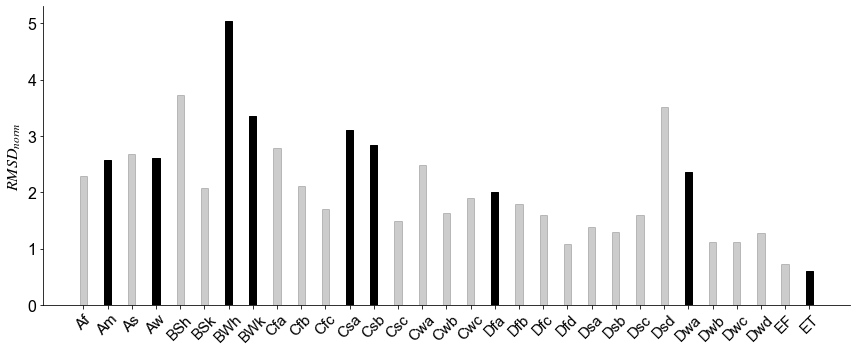

In [26]:
width= 0.3
fig= plt.figure(figsize=(12,5))
ax= fig.add_subplot()
# figBar1= ax.bar(np.arange(len(rmseZoneMedian)), rmseZoneMedian,width=width,log=False, color='red', edgecolor='black', label='median of rmse over zone', alpha=0.2)
figBar1= ax.bar(np.arange(len(rmseZoneMedianNorm)), rmseZoneMedianNorm,width=width,log=False, color='k', edgecolor='black', label='normalized median RMSD at all pixels', alpha=0.2)
ax.bar([1], rmseZoneMedianNorm['Am'], color='k', edgecolor='black', width=width)
ax.bar([3], rmseZoneMedianNorm['Aw'], color='k', edgecolor='black', width=width)
# ax.bar([4], rmseZoneMedianNorm['BSh'], color='green', edgecolor='black', width=width)
ax.bar([6], rmseZoneMedianNorm['BWh'], color='k', edgecolor='black', width=width)
ax.bar([7], rmseZoneMedianNorm['BWk'], color='k', edgecolor='black', width=width)
# ax.bar(8, rmseZoneMedianNorm['Cfa'], color='green', edgecolor='black', width=width)
ax.bar(11, rmseZoneMedianNorm['Csa'], color='k', edgecolor='black', width=width)
ax.bar(12, rmseZoneMedianNorm['Csb'], color='k', edgecolor='black', width=width)
ax.bar(17, rmseZoneMedianNorm['Dfa'], color='k', edgecolor='black', width=width)
ax.bar(25, rmseZoneMedianNorm['Dwa'], color='k', edgecolor='black', width=width)
ax.bar(30, rmseZoneMedianNorm['ET'], color='k', edgecolor='black', width=width)
# ax2= ax.twinx()
# figBar2= ax2.bar(np.arange(len(rmseZoneMedian))+width, rmseZoneMedianNorm, width=width, color='black', edgecolor='black', label='normalized median by rain rate over zone', alpha=0.2)
# figBar2= ax.bar(np.arange(len(rmseZoneGaugeMedianNorm))+width, rmseZoneGaugeMedianNorm, width=width, color='blue', edgecolor='black', label='normalized median RMSD at gauge pixels', alpha=0.2)
# ax.bar(1.3, rmseZoneGaugeMedianNorm['Am'], color='blue', edgecolor='black', width=width)
# ax.bar(3.3, rmseZoneGaugeMedianNorm['Aw'], color='blue', edgecolor='black', width=width)
# # ax.bar(4.3, rmseZoneGaugeMedianNorm['BSh'], color='blue', edgecolor='black', width=width)
# ax.bar(6.3, rmseZoneGaugeMedianNorm['BWh'], color='blue', edgecolor='black', width=width)
# ax.bar([7.3], rmseZoneGaugeMedianNorm['BWk'], color='blue', edgecolor='black', width=width)
# # ax.bar(8.3, rmseZoneGaugeMedianNorm['Cfa'], color='blue', edgecolor='black', width=width)
# ax.bar(11.3, rmseZoneGaugeMedianNorm['Csa'], color='blue', edgecolor='black', width=width)
# ax.bar(12.3, rmseZoneGaugeMedianNorm['Csb'], color='blue', edgecolor='black', width=width)
# ax.bar(17.3, rmseZoneGaugeMedianNorm['Dfa'], color='blue', edgecolor='black', width=width)
# ax.bar(25.3, rmseZoneGaugeMedianNorm['Dwa'], color='blue', edgecolor='black', width=width)
# ax.bar(30.3, rmseZoneGaugeMedianNorm['ET'], color='blue', edgecolor='black', width=width)
# ax.set_xlim([-0.5,len(rmseZoneMedian)])
# ax.legend(loc='upper left',fontsize=15)
ax.set_xticks(np.arange(len(rmseZoneMedian)))
ax.set_xticklabels(rmseZoneMedian.index, position=(1.5, 0), fontsize=15)  
ax.xaxis.set_tick_params(rotation=45)
# ax.bar(['Am'], rmseZoneMedian['Am'], color='red', edgecolor='black', width=width)
ax.set_ylabel('$RMSD_{norm}$',fontsize=16)
# ax2.set_ylabel('normalized rms difference')
                                            
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles_1, labels_1 = ax.get_legend_handles_labels()
# handles_2, labels_2 = ax2.get_legend_handles_labels()
# ax.get_legend().remove()
# ax2.get_legend().remove()
# labels_1= labels_1+ labels_2
# handles_1= handles_1+ handles_2
# ax_add= fig.add_axes((.6,0.8,0.1,0.1), facecolor='white', xticks=[], yticks=[], frameon=False)
# ax_add.set_facecolor("white")

# plt.legend(handles_1,labels_1)
plt.tight_layout();
fig.savefig('climZoneStat_woGauge.png', dpi=300);

In [91]:
from taylor import TaylorDiagram

In [92]:
def taylorZone(samples):
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = np.array([samples[i][0] for i in range(len(samples))]).min()

    # Samples std,rho,name
#     density= normalize(np.array([continentAmount.loc[key,:].density for key in continentAmount.index]),'minmax')
#     samples = [[continentAmount.loc[key,:].rmsd, density[i], key] for i, key in enumerate(continentAmount.index)]

    fig = plt.figure(figsize=(6,6))

    dia = TaylorDiagram(stdref, fig=fig, label='Min', extend=False, srange=(0,3))
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star
    colors = plt.matplotlib.cm.rainbow(np.linspace(0, 1, 8))
#     print(colors)
    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        if name[0]=='A':
            marker= 'o'
        elif name[0]=='B':
            marker= '>'
        elif name[0]=='C':
            marker= '*'
        elif name[0]=='D':
            marker= 's'
        elif name[0]=='E':
            marker= 'D'
        rank= 'TFdcbakh'
        if name[-1] in rank:
            color= colors[rank.find(name[-1]),:]
        else:
            color='red'
#         print(color)
        dia.add_sample(stddev, corrcoef,
                       marker=marker, ms=10, ls='',
                       mfc=color,mec=color,
#                        mfc='k', mec='k',
                       label=str(name))

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
#     plt.xlim([1,1.5])
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
#     fig.legend(dia.samplePoints,
#                [ p.get_label() for p in dia.samplePoints ],
#                numpoints=1, prop=dict(size='large'), loc=(0.9, 0.1))
#     cbar= fig.add_axes((0.48,0.97,.4,.01))
#     cb = plt.colorbar(orientation='horizontal', mappable= plt.matplotlib.cm.ScalarMappable(cmap=plt.matplotlib.cm.rainbow), cax=cbar, fraction=0.70, shrink=0.7,ticks=[0,1,2,3,4])
#     cb.set_label('Temperature', fontsize=15)
#     cb.ax.set_xticks(range(5))
#     cb.ax.set_xticklabels(['cold','hot'], fontsize=15)
    
#     for tick in fig.xaxis.get_major_ticks():
#         tick.label.set_fontsize(15) 
#     for tick in fig.yaxis.get_major_ticks():
#         tick.label.set_fontsize(15) 
#     fig.suptitle("Taylor diagram", size='x-large')  # Figure title
#     fig.savefig('taylor diagram climateZone.png', dpi=300)
    return dia

In [82]:
(gaugeZoneDensity-gaugeZoneDensity.min())/(gaugeZoneDensity.max()-gaugeZoneDensity.min())

zone
Af     0.050659
Am     0.036538
As     0.009725
Aw     0.121484
BSh    0.060110
BSk    0.102527
BWh    0.079176
BWk    0.028571
Cfa    0.232143
Cfb    1.000000
         ...   
Dsa    0.003407
Dsb    0.004835
Dsc    0.006319
Dsd    0.000000
Dwa    0.022802
Dwb    0.028681
Dwc    0.031648
Dwd    0.001758
EF     0.001648
ET     0.047418
Name: gauge_sum, Length: 31, dtype: float64

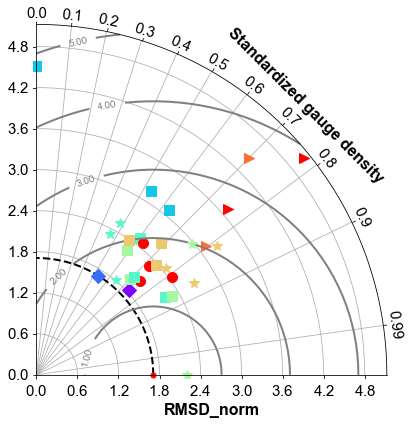

In [93]:
samples= [[np.nanmedian(zoneRMSDs[i])*2, gaugeZoneDensity.values[i]**.1, gaugeZoneDensity.index[i]] for i in range(len(rmseZoneGaugeMedian))]
taylorZone(samples)

### Regional statistics

<img src="graphs/regionalPlot.png" width="60%"> </img>

In [32]:
regionStats= pd.read_csv('regionsStats.csv')

In [21]:
regionStats.head()

id      area  _gauge_num     ele_sum     ele_mean  ele_median  ele_min  \
0   1  450599.0        14.0   1381984.5   379.770404       382.0    179.0   
1   2  809321.0       120.0   1043975.5   160.463495       123.0      4.0   
2   3  220053.0        32.0    485625.0   272.058824       260.0    117.0   
3   4  339397.0         0.0    607708.5   222.034527       237.0      0.0   
4   5  344136.0       392.0  52185462.0  1877.174892       480.0      0.0   

   ele_max  ele_range  rain_count  ...    rain_media      rain_min  \
0    603.0      424.0      3647.0  ...  14085.250977  10293.818359   
1    647.0      643.0      6586.0  ...  26072.256836  18165.957031   
2    766.0      649.0      1763.0  ...  26224.531250  21909.585938   
3    496.0      496.0      2740.0  ...  11129.833496   3138.211426   
4   6467.5     6467.5     27738.0  ...   9392.888184    433.317169   

       rain_max    rain_range  rmsd_count  rmsd_media  rmsd_stdev  rmsd_min  \
0  24424.843750  14131.025391        3223    1.347225    0.240326  0.715650   
1  32839.675781  14673.718750        6458    1.631332    0.219707  1.179975   
2  28492.482422   6582.896484        1764    1.602926    0.178971  1.338436   
3  14767.136719  11628.925293        2399    1.323977    0.277665  0.667099   
4  64477.453125  64044.135956       27288    1.457979    0.507423  0.253997   

   rmsd_max  rmsd_range  
0  2.041228    1.325578  
1  2.343259    1.163284  
2  2.144274    0.805838  
3  2.111461    1.444363  
4  2.990808    2.736811  

[5 rows x 21 columns]

In [82]:
def preprocess(csv, colname='uncertainty'):
    df= pd.read_csv(csv)
    df['gauge_density']= df.gauge_sum/df['AREA_SQKM']
    df['uncertainty']= df.rmsd_media/df.gauge_density
    df= df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    return df
    

In [83]:
import os
_dict= {}
for file in os.listdir('catchments'):
    if file.endswith('.csv'):
        uncer= preprocess('catchments/%s'%file)
        name= file.split('.')[0]
        _dict[name]= uncer

In [84]:
continentAmount= pd.read_csv('continentsRain.csv')

In [85]:
continentAmount.set_index('CONTINENT', inplace=True)

In [86]:
continentAmount= continentAmount.loc[['Asia','North America', 'Europe','Africa','South America', 'Australia'],:]

In [87]:
continentAmount.index= [ 'Asia','NorthAmerica','Europe','Africa', 'SouthAmerica',  'Australia']

In [88]:
_dict.keys()

dict_keys(['ca', 'NorthAmerica', 'Asia', 'SouthAmerica', 'Africa', 'Euro', 'Austrilia'])

In [89]:
_dict['Europe']= _dict.pop('Euro')

In [90]:
_dict['Australia']= _dict.pop('Austrilia')

In [91]:
_dict['NorthAmerica'].gauge_density.sum()

19.367198179532526

In [92]:
_dict['Asia'].head()

BASIN_ID  AREA_SQKM  rmsd_media  gauge_medi  gauge_sum  gauge_density  \
0           1   449831.6    0.529658         0.0       20.0       0.000044   
1           2   118875.8    0.521792         0.0        4.0       0.000034   
2           3  1456238.9    0.564074         0.0      112.0       0.000077   
18         19    86780.8    0.489812         0.0        3.0       0.000035   
469       470   704369.7    0.776186         0.0       54.0       0.000077   

      uncertainty  
0    11912.847730  
1    15507.108426  
2     7334.162216  
18   14168.766875  
469  10124.475214

In [93]:
_dict.keys()

dict_keys(['ca', 'NorthAmerica', 'Asia', 'SouthAmerica', 'Africa', 'Europe', 'Australia'])

In [94]:
continentAmount

_sum         _mean  far_median
Asia          6.244742e+09  11494.370053    0.252059
NorthAmerica  3.036327e+09   8189.003361    0.239287
Europe        1.836237e+09  12705.499325    0.248248
Africa        3.297362e+09  12884.649415    0.207035
SouthAmerica  4.635571e+09  30101.892608    0.209877
Australia     6.658864e+08   9570.358865    0.213785

In [95]:
# continentAmount['rmsd']= [np.nanmedian(_dict[key].rmsd_media/(continentAmount['_mean'][key]/6969/48)**.5) for key in continentAmount.index]
continentAmount['rmsd']= [np.nanmedian(_dict[key].rmsd_media) for key in continentAmount.index]

In [96]:
continentAmount['density']= [np.nansum(_dict[key].gauge_density) for key in continentAmount.index]

In [97]:
continentAmount.head()

_sum         _mean  far_median      rmsd    density
Asia          6.244742e+09  11494.370053    0.252059  1.208528  20.747599
NorthAmerica  3.036327e+09   8189.003361    0.239287  1.197344  19.367198
Europe        1.836237e+09  12705.499325    0.248248  1.084373  56.936421
Africa        3.297362e+09  12884.649415    0.207035  1.412645   3.816675
SouthAmerica  4.635571e+09  30101.892608    0.209877  1.192079   3.178455

In [137]:

def talorContinent(samples):
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = np.array([samples[i][0] for i in range(len(samples))]).min()

    # Samples std,rho,name
#     density= normalize(np.array([continentAmount.loc[key,:].density for key in continentAmount.index]),'minmax')
#     samples = [[continentAmount.loc[key,:].rmsd, density[i], key] for i, key in enumerate(continentAmount.index)]

    fig = plt.figure(figsize=(6,6))

    dia = TaylorDiagram(stdref, fig=fig, label='Min', extend=False, srange=(0,1.6))
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star
    colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(samples)))
#     print(colors)
    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        if name=='Asia':
            marker= 'o'
            color='C2'
        elif name=='SouthAmerica':
            marker= '>'
            color='C3'
        elif name=='NorthAmerica':
            marker= '*'
            color='C1'
        elif name=='Africa':
            marker= 's'
            color='C5'
        elif name=='Europe':
            marker= 'D'
            color= 'C0'
        elif name=='Australia':
            marker= '^'
            color='C4'
        dia.add_sample(stddev, corrcoef,
                       marker=marker, ms=15, ls='',
#                        mfc=,
                       mfc=color, mec=color,
                       label=str(name))

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey

#     plt.xlim([1,1.5])
    plt.clabel(contours, inline=1, fontsize=12, fmt='%.2f')
    plt.text(1.4, 1.8, 'Asia', fontsize=15, weight='bold')
    plt.text(1.0, 2.1, 'North America', fontsize=15, weight='bold')
    plt.text(2.1, 0, 'Europe', fontsize=15, weight='bold', rotation=-45)
    plt.text(samples[3][1], 2.9, 'Africa', fontsize=15, weight='bold')
    plt.text(samples[4][1], 1.8, 'South America', fontsize=15,rotation=-45, weight='bold')
    plt.text(1.2, 2.55, 'Australia', fontsize=15, weight='bold')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward
    
    dia.ax.axis['bottom'].major_ticklabels.set_fontsize(20)
    # Add a figure legend and title
#     fig.legend(dia.samplePoints,
#                [ p.get_label() for p in dia.samplePoints ],
#                numpoints=1, prop=dict(size='large'), loc='upper right')
#     fig.suptitle("Taylor diagram", size='x-large')  # Figure title
    fig.savefig('taylor diagram.png', dpi=300)
    return dia



In [108]:
continentAmount.index

Index(['Asia', 'NorthAmerica', 'Europe', 'Africa', 'SouthAmerica',
       'Australia'],
      dtype='object')

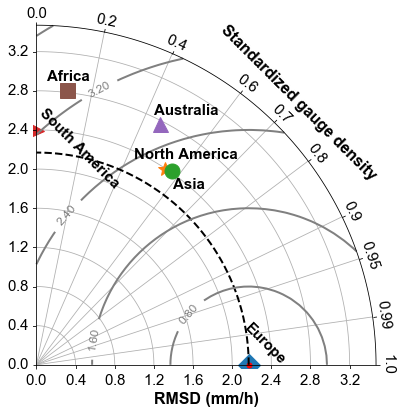

In [138]:
density= normalize(np.array([continentAmount.loc[key,:].density for key in continentAmount.index]),'minmax')
samples = [[continentAmount.loc[key,:].rmsd*2, np.sqrt(density[i]), key] for i, key in enumerate(continentAmount.index)]
talorContinent(samples)

In [52]:
[[continentAmount.loc[key,:].rmsd, continentAmount.loc[key,:].far_median, key] for key in continentAmount.index]

[[6.519583081981846, 0.252058818936348, 'Asia'],
 [7.65260643234357, 0.239286676049232, 'NorthAmerica'],
 [5.564021760701951, 0.24824778735637698, 'Europe'],
 [7.197846473283531, 0.20703510195016897, 'Africa'],
 [3.973874054059653, 0.20987680554389998, 'SouthAmerica'],
 [8.185447895893352, 0.21378485113382298, 'Australia']]

In [102]:
_dict['northAmerica']= pd.concat([_dict['ca'], _dict['NorthAmerica']])

In [103]:
continentAmount['norm']= normalize(continentAmount._mean, 'minmax')+1

In [104]:
for name, arr in _dict.items():
    print(name,np.nanmedian(arr['rmsd_media']))

ca 1.4017648696899399
NorthAmerica 1.1973443031311002
Asia 1.2085275650024399
SouthAmerica 1.1920793056488
Africa 1.4126449823379499
Europe 1.0843733549118
Australia 1.3845247030258199
northAmerica 1.2105963230133099


Asia
SouthAmerica
Africa
Europe
Australia
northAmerica


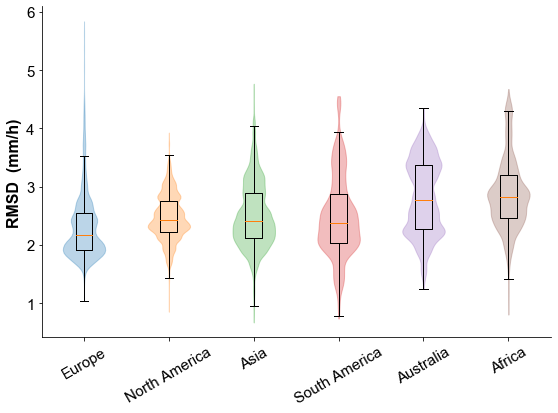

In [106]:
fig= plt.figure(figsize=(8,6))
# fig.subplots_adjust(hspace=0)
# spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2,1])
ind= np.arange(0,6)
width= 1
i=0
labels= []
gauge_sum= [_dict[key].gauge_sum.sum() for key in labels]
positions= [2, 3, 5, 0, 4, 1]
colors= ['C%d'%i for i in positions]
ax= fig.add_subplot()
for name, arr in _dict.items():
    if name in ['Europe', 'northAmerica', 'Asia', 'SouthAmerica','Australia', 'Africa']:

        pc= ax.violinplot(arr['rmsd_media']*2, positions= [positions[i]], showmedians=False,showextrema=False)
        
        for pc in pc['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
#             pc.set_linecolor(colors[i])
        pc= ax.boxplot(arr['rmsd_media']*2, positions= [positions[i]], showfliers=False, widths=0.2)
        i+=1
        print(name)
        if name=='northAmerica':
            labels.append('NorthAmerica')
        else:
            labels.append(name)
        
# ax2= ax.twinx()
# ax2.bar(ind-0.3, continentAmount.loc[labels,:].norm.values, width=0.3, color='blue', alpha=0.5,edgecolor='black', label='normalized rain amount')
# ax2.bar(ind, normalize(np.array([int(_dict[key]['gauge_sum'].sum()) for key in labels]), method='minmax')+1, width=0.3, color='red',edgecolor='black', alpha=0.5, label='normalized gauge number')
# ax2.bar(ind+0.3, normalize(np.array([len(_dict[key]) for key in labels]), method='minmax')+1, edgecolor='black', color='black', width=0.3, alpha=0.5, label='normalized samples')
# ax2.set_ylim([0.5,4])
# ax2.set_yticks(np.arange(0,60000,20000))
# ax2.set_yticklabels(np.arange(0,60000,20000))
# ax2.set_ylim(ax2.get_ylim()[::-1])
# ax2.set_ylabel('')
# ax2.legend(loc=(.6,0.4), fontsize=12)

# ax2.set_yticks(np.arange(0.5,4.5,0.5))
# ax2.set_yticklabels(['',0,0.5,1], fontsize=15)

ax.set_ylabel('RMSD  (mm/h)', fontsize=16)
# ax.set_ylim([0,6])
ax.set_xticks(ind)
ax.set_xticklabels(['Europe', 'North America', 'Asia', 'South America', 'Australia', 'Africa'], fontsize=15)
ax.xaxis.set_tick_params(rotation=30)
for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
# for tick in ax2.yaxis.get_major_ticks():
#         tick.label.set_fontsize(15)
# plt.xticks(rotation=10)
# ax.set_xlim([-0.5,7])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout();
fig.savefig('continental_rmsd_woBar.png', dpi=300);

In [41]:
sample= gpd.read_file('/Users/allen/Documents/global_river_basin/hydrosheds-4df7fa881fbe25464863/ca_bas_30s_beta/ca_bas_30s_beta.shp')

In [42]:
sample['uncertainty']= _dict['ca']

In [43]:
sample.to_file('gisSrc/CentralAmerica')

In [38]:
_dict.keys()

dict_keys(['ca', 'NorthAmerica', 'Asia', 'SouthAmerica', 'Africa', 'Euro', 'Austrilia'])

### Information Entropy weight

In [294]:
def e1(rmse, mae, far, bias):
    # normalize by gaussian
    rmse[rmse<0]= np.nan
    mae[mae<0]= np.nan
    bias[bias<0]= np.nan
    far[far<0]= np.nan
    mae_norm= normalize(mae, method='minmax')
    rmse_norm= normalize(rmse, method='minmax')
    bias_norm= normalize(bias, method='minmax')
    far_norm= normalize(far, method='minmax')
    mae_normByMax= mae_norm/np.nansum(np.nanmax(mae_norm)+np.nanmax(rmse_norm)+np.nanmax(bias_norm)+ np.nanmax(far_norm))
    rmse_normByMax= rmse_norm/np.nansum(np.nanmax(mae_norm)+np.nanmax(rmse_norm)+np.nanmax(bias_norm)+ np.nanmax(far_norm))
    bias_normByMax= bias_norm/np.nansum(np.nanmax(mae_norm)+np.nanmax(rmse_norm)+np.nanmax(bias_norm)+ np.nanmax(far_norm))
    far_normByMax= far_norm/np.nansum(np.nanmax(mae_norm)+np.nanmax(rmse_norm)+ np.nanmax(far_norm))
    e1= -(mae_normByMax*np.log(mae_normByMax)+rmse_normByMax*np.log(rmse_normByMax)+ far_normByMax*np.log(far_normByMax)+ bias_normByMax*np.log(bias_normByMax))
    e1= normalize(e1, method='minmax')
    
    return e1

def e2(tiff):
    
    gauge_density= gdal.Open('geotiffs/GPCC_gauges.tif')
    arr= gauge_density.ReadAsArray()
    arr[arr==0]= 0.1
#     arr+=1
    density= 11*11/arr
#     density[(density==np.inf)| np.isnan(density) | (density==-np.inf)]= 1e-3
#     inv= np.log10(arr)
#     inv= arr.max()/arr
#     inv[inv==np.inf]=100
    inv_norm= normalize(density, method='minmax')
#     inv_norm= (inv-np.nanmin(inv))/(np.nanmax(inv)-np.nanmin(inv)+1)
    e2= -inv_norm*np.log(inv_norm)
#     e2=1/e2
#     e2= normalize(e2, method='minmax')
    geotrans= gauge_density.GetGeoTransform()
    rows, cols= e2.shape
    
    driver = gdal.GetDriverByName('GTiff')
    outdata = driver.Create('e2.tif', cols, rows, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform(geotrans)
    outdata.SetProjection("EPSG:4326")
    outdata.GetRasterBand(1).WriteArray(e2)
    
    return e2

def e3(raster1, raster2, raster3, geotrans):
    
    ras1, ras2, ras3= raster1.ReadAsArray(), raster2, raster3
    ras1= np.flip(ras1, axis=0)
    ras1= np.nanmax(ras1)-ras1
    ras1_norm= normalize(ras1, method='minmax')
    ras2_norm= normalize(ras2, method='minmax')
    ras3_norm= normalize(ras3, method='minmax')
    ras1_normByMax= ras1_norm/np.nansum(np.nanmax(ras1_norm)+np.nanmax(ras2_norm)+np.nanmax(ras3_norm))
    ras2_normByMax= ras2_norm/np.nansum(np.nanmax(ras1_norm)+np.nanmax(ras2_norm)+np.nanmax(ras3_norm))
    ras3_normByMax= ras3_norm/np.nansum(np.nanmax(ras1_norm)+np.nanmax(ras2_norm)+np.nanmax(ras3_norm))
    e3= -(ras1_normByMax*np.log(ras1_normByMax)+ras2_normByMax*np.log(ras2_normByMax)+ ras3_normByMax*np.log(ras3_normByMax))
    e3= normalize(e3, method='minmax')
#     geotrans= raster1.GetGeoTransform()
    rows, cols= e3.shape
    
    driver = gdal.GetDriverByName('GTiff')
    outdata = driver.Create('e3.tif', cols, rows, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform(geotrans)
    outdata.SetProjection("EPSG:4326")
    outdata.GetRasterBand(1).WriteArray(e3)
    
    return e3

In [87]:
import sys
sys.path.append('/Users/allen/Documents/Python/geoPackage')
from geoPackage.raster import Geoprocess
from geoPackage.io import ReadFile

In [135]:
final_max= ReadFile('geotiffs/max_for_dem.tif').raster
# final_max= Geoprocess(final_max).rasterClipByExt(extent=(-180.0,180.0,-56.0,84.0), dst='geotiffs/sample.tif')

In [245]:
final_sum= ReadFile('geotiffs/total_for_dem.tif').raster

In [138]:
arr_max= final_max.array
arr_max[arr_max<0]= np.nan
arr_sum= final_sum.array
arr_sum[arr_sum<0]= np.nan

In [139]:
dem= gdal.Open('geotiffs/global_elevation.tif')

In [282]:
e3(dem, arr_sum, arr_max)

TypeError: e3() missing 1 required positional argument: 'geotrans'

In [171]:
bias= abs(result['final sum'][:]- result['early sum'][:])

In [295]:
first= e1(rmse, mae, FAR, bias/6969/48.)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [296]:
array2raster('e1.tif', first, lon_diff, lons, lat_diff, lats)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1295ef0f0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1295ef0f0> >


In [43]:
final_max= result['final max'][:]

In [297]:
third= e3(dem, arr_sum/19., arr_max, final_sum.geotransform)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


In [293]:
second= e2('GPCC_gauges.tif')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


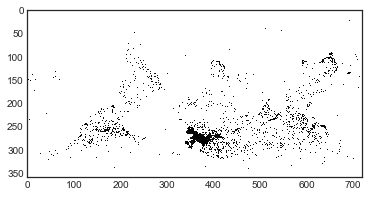

In [262]:
plt.imshow(np.flip(second,axis=0))

In [267]:
def EVI(e1, e2, e3):
    e2= cv2.resize(np.flip(e2,axis=0), (3600,1400))
    e1= cv2.resize(e1, (3600,1400))
    e3= cv2.resize(e3, (3600,1400))
    final_sum.geotransform
    v1= e1/(e1+e2+(1-e3))
    v2= e2/(e1+e2+(1-e3))
    v3= (1-e3)/(e1+e2+(1-e3))
    
    return v1*0.5+ v2*0.3+ v3*0.2

In [269]:
evi= EVI(first, second, third)

In [222]:
from geoPackage.visualize import layout

In [271]:
driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('EVI.tif', cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(final_sum.geotransform)
outdata.SetProjection("EPSG:4326")
outdata.GetRasterBand(1).WriteArray(evi)


0

In [110]:
len(e2[e2>0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


7856

In [201]:
gauge_density= gdal.Open('GPCC_gauges.tif')
arr= gauge_density.ReadAsArray()

(array([6.00000e+00, 4.00000e+00, 2.00000e+01, 7.30000e+01, 1.12000e+02,
        1.77000e+02, 2.45000e+02, 6.26000e+02, 2.71200e+03, 2.55225e+05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

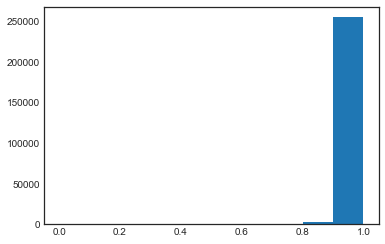

In [211]:
plt.hist(e2.reshape(-1,1))

(array([2.51343e+05, 3.88200e+03, 2.71200e+03, 3.95000e+02, 3.60000e+02,
        2.49000e+02, 1.36000e+02, 9.30000e+01, 2.10000e+01, 9.00000e+00]),
 array([0.        , 0.16232494, 0.32464987, 0.48697478, 0.64929974,
        0.81162465, 0.97394955, 1.1362745 , 1.2985995 , 1.4609244 ,
        1.6232493 ], dtype=float32),
 <a list of 10 Patch objects>)

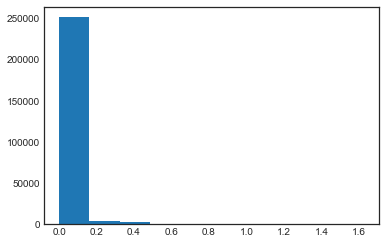

In [207]:
plt.hist(np.log10(arr+1).reshape(-1,1))

In [172]:
total= gdal.Open('geotiffs/total_for_dem.tif')
elev= gdal.Open('geotiffs/global_elevation.tif')

In [68]:
total.ReadAsArray().shape==elev.ReadAsArray().shape

True

In [173]:
e3(total, elev)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply


In [94]:
gauge_density= gdal.Open('GPCC_gauges.tif')
arr= gauge_density.ReadAsArray()
inv= np.nanmax(arr)-arr
inv= normalize(inv, method='minmax')
e2= -inv_norm/np.nanmax(inv)*np.log(inv/np.nanmax(inv))
e2[e2==np.inf=1]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)